# 내용 요약
목적  
* 더 나은 서비스 제공과 고객 만족도 개선을 위한 데이터 분석

분석 절차
1. 문제 발견
  1_1. 퍼널 분석
  1_2. 신규 고객 유입 시계열 그래프
  1_3. 고객 문의 유형별 작업 처리상태와 고객의 감정분석

> 목적 도출

2. 목적에 따른 분석
  2_1. AB test
  2_2. 코호트 분석


In [ ]:
#데이터는 https://github.com/alexkwj/project_Log_Analysis > data에 제공

import pandas as pd

users = pd.read_csv('/content/drive/MyDrive/project4/data/users.csv')
event_logs= pd.read_csv('/content/drive/MyDrive/project4/data/event_logs.csv')
payment_transactions= pd.read_csv('/content/drive/MyDrive/project4/data/payment_transactions.csv')
plan_history= pd.read_csv('/content/drive/MyDrive/project4/data/plan_history.csv')
ab_assignment= pd.read_csv('/content/drive/MyDrive/project4/data/ab_assignment.csv')
referral_events= pd.read_csv('/content/drive/MyDrive/project4/data/referral_events.csv')
chat_events= pd.read_csv('/content/drive/MyDrive/project4/data/chat_events.csv')
push_events= pd.read_csv('/content/drive/MyDrive/project4/data/push_events.csv')
campaigns= pd.read_csv('/content/drive/MyDrive/project4/data/campaigns.csv')

In [ ]:
# 시각화 폰트 적용 필수!!
!pip install koreanize_matplotlib

In [ ]:
event_logs['event_name'].unique()

array(['signup_completed', 'lesson_played', 'course_searched',
       'chat_sent', 'page_viewed', 'quiz_submitted',
       'first_quiz_submitted', 'first_lesson_played', 'course_wishlisted',
       'push_sent', 'payment_completed', 'pricing_page_viewed',
       'subscription_canceled', 'onboarding_cta_clicked',
       'checkout_started'], dtype=object)

In [ ]:
event_logs.head(100)
cod = event_logs['event_name'] == 'chat_sent'
sum(cod)

1878

# 퍼널분석

In [ ]:
import pandas as pd

# 데이터 로드
# 단계별 이벤트 그룹 정의
funnel_steps = {
    "signup": ["signup_completed"],
    "explore": ["course_searched", "page_viewed"],
    "consideration": ["pricing_page_viewed", "course_wishlisted"],
    "purchase": ["payment_completed"]
}

# user_id별 각 단계 도달 여부 계산
funnel_df = pd.DataFrame({"user_id": event_logs["user_id"].unique()})

for step, events in funnel_steps.items():
    funnel_df[step] = funnel_df["user_id"].isin(
        event_logs[event_logs["event_name"].isin(events)]["user_id"]
    )

# 단계별 유저 수
stage_counts = funnel_df.drop(columns="user_id").sum().reset_index()
stage_counts.columns = ["stage", "user_count"]

print(stage_counts)


           stage  user_count
0         signup       22545
1        explore       20426
2  consideration       10375
3       purchase        4962


In [ ]:
event_logs['event_name'].value_counts()

,count
event_name,
lesson_played,281218
first_lesson_played,96156
page_viewed,96038
quiz_submitted,81923
course_searched,57228
first_quiz_submitted,56372
signup_completed,22545
pricing_page_viewed,8783
payment_completed,4962


In [ ]:
# df = event_logs['first_lesson_played'] / event_logs['lesson_played']

In [ ]:
# import numpy as np
# import plotly.graph_objects as go

# # 1) 진짜 퍼널 수치(누적 AND) 계산
# ordered_steps = ["signup", "explore", "consideration", "purchase"]

# mask = None
# progressive_counts = []
# for i, step in enumerate(ordered_steps):
#     if i == 0:
#         mask = funnel_df[step]
#     else:
#         mask = mask & funnel_df[step]
#     progressive_counts.append(int(mask.sum()))

# # 2) 퍼널 차트 (Plotly Funnel)
# fig = go.Figure(go.Funnel(
#     y = ordered_steps,               # 단계 순서 고정
#     x = progressive_counts,          # 누적 AND 값
#     textposition = "inside",
#     textinfo = "value+percent initial+percent previous",
#     opacity = 0.85,
#     hovertemplate = (
#         "Stage: %{y}<br>"
#         "Users: %{x:,}<br>"
#         "Step Conv: %{percentPrevious:.1%}<br>"
#         "Overall: %{percentInitial:.1%}<extra></extra>"
#     ),
# ))

# fig.update_layout(
#     title="Funnel (Progressive AND)",
#     margin=dict(l=40, r=40, t=60, b=40),
# )
# fig.show()


In [ ]:
# total_users = funnel_df["user_id"].nunique()

# # OR 방식 (단계 이벤트 중 하나라도 발생한 유저)
# users_any = []
# for step, events in funnel_steps.items():
#     cnt = event_logs[event_logs["event_name"].isin(events)]["user_id"].nunique()
#     users_any.append(cnt)

# # AND 방식 (이전 단계 전부 통과)
# mask = None
# users_progressive = []
# for i, step in enumerate(ordered_steps):
#     if i == 0:
#         mask = funnel_df[step]
#     else:
#         mask = mask & funnel_df[step]
#     users_progressive.append(mask.sum())

# # 전체 비중 계산
# overall_any_pct = [round(x / total_users * 100, 2) for x in users_any]
# overall_progressive_pct = [round(x / total_users * 100, 2) for x in users_progressive]

# # 통합 테이블
# summary = pd.DataFrame({
#     "stage": ordered_steps,
#     "users_progressive": users_progressive,
#     "users_any": users_any,
#     "overall_%_progressive": overall_progressive_pct,
#     "overall_%_any": overall_any_pct
# })
# #
# print(summary)


## 퍼널분석 인사이트  
1 . 퍼널 분석(and)로 구했을때  
전체 구매자(4,962명) 중 퍼널 경로를 모두 따른 고객은 2,999명뿐 → 약 40%의 구매자가 중간 단계를 생략하고 바로 구매.

2.  시긱화 그래프를 봤을때  
탐색 > 고려 = 46%  
고려 > 구매 = 13%만 구매

funnel_steps = {  
    "signup": ["signup_completed"],  
    "explore": ["course_searched", "page_viewed"],  
    "consideration": ["pricing_page_viewed", "course_wishlisted"],  
    "purchase": ["payment_completed"]  
}


## 퍼널분석2
팀원의 요청으로
firsted_lesson_played까지

In [ ]:
# import pandas as pd

# # 데이터 로드
# # 단계별 이벤트 그룹 정의
# funnel_steps = {
#     "signup": ["signup_completed"],
#     "explore": ["course_searched", "page_viewed"],
#     "consideration": ["pricing_page_viewed", "course_wishlisted"],
#     "purchase": ["payment_completed"]
# }

# # user_id별 각 단계 도달 여부 계산
# funnel_df = pd.DataFrame({"user_id": event_logs["user_id"].unique()})

# for step, events in funnel_steps.items():
#     funnel_df[step] = funnel_df["user_id"].isin(
#         event_logs[event_logs["event_name"].isin(events)]["user_id"]
#     )

# # 단계별 유저 수
# stage_counts = funnel_df.drop(columns="user_id").sum().reset_index()
# stage_counts.columns = ["stage", "user_count"]

# print(stage_counts)

# import numpy as np
# import plotly.graph_objects as go

# # 1) 퍼널
# ordered_steps = ["signup", "explore", "consideration", "purchase"]

# mask = None
# progressive_counts = []
# for i, step in enumerate(ordered_steps):
#     if i == 0:
#         mask = funnel_df[step]
#     else:
#         mask = mask & funnel_df[step]
#     progressive_counts.append(int(mask.sum()))

# # 2) 퍼널 차트 (Plotly Funnel)
# fig = go.Figure(go.Funnel(
#     y = ordered_steps,               # 단계 순서 고정
#     x = progressive_counts,          # 누적 AND 값
#     textposition = "inside",
#     textinfo = "value+percent initial+percent previous",
#     opacity = 0.85,
#     hovertemplate = (
#         "Stage: %{y}<br>"
#         "Users: %{x:,}<br>"
#         "Step Conv: %{percentPrevious:.1%}<br>"
#         "Overall: %{percentInitial:.1%}<extra></extra>"
#     ),
# ))

# fig.update_layout(
#     title="Funnel (Progressive AND)",
#     margin=dict(l=40, r=40, t=60, b=40),
# )
# fig.show()



In [ ]:
import pandas as pd

# 2. 퍼널 단계 정의
funnel_steps = {
    '유입': ['signup_completed'],
    '탐색': ['page_viewed', 'course_searched'],
    '경험': ['first_lesson_played'],
    '관여': ['chat_sent', 'course_wishlisted', 'first_quiz_submitted'],
    '구매': ['payment_completed']
}

# 3. 단계별 유저 집합 (AND 기반)
funnel_users = {}
previous_users = None

for step, events in funnel_steps.items():
    # 해당 단계 이벤트를 한 유저 집합
    step_users = set(
        event_logs.loc[event_logs['event_name'].isin(events), 'user_id'].unique()
    )

    if previous_users is None:
        # 첫 단계(유입)
        funnel_users[step] = step_users
    else:
        # AND 기반: 이전 단계 유저 중에서만 다음 단계 필터링
        funnel_users[step] = previous_users & step_users

    previous_users = funnel_users[step]

# 4. 결과 테이블 생성
funnel_result = pd.DataFrame({
    '단계': list(funnel_users.keys()),
    '유저 수': [len(users) for users in funnel_users.values()]
})

# 5. 전체 대비 비율
total_first_step = len(funnel_users['유입'])
funnel_result['전체 대비 %'] = (
    funnel_result['유저 수'] / total_first_step * 100
).round(2)

# 6. 이전 단계 대비 비율
funnel_result['이전 단계 대비 %'] = (
    funnel_result['유저 수'].pct_change().add(1).mul(100).round(2)
)
funnel_result.iloc[0, funnel_result.columns.get_loc('이전 단계 대비 %')] = 100.0

# 7. 결과 출력
print(funnel_result)





   단계   유저 수  전체 대비 %  이전 단계 대비 %
0  유입  22545   100.00      100.00
1  탐색  20426    90.60       90.60
2  경험  20096    89.14       98.38
3  관여  17300    76.74       86.09
4  구매   4737    21.01       27.38


In [ ]:
# import plotly.graph_objects as go

# # 1) 데이터 꺼내기
# ordered_steps = funnel_result['단계'].tolist()
# counts        = funnel_result['유저 수'].tolist()

# # 2) 퍼널 차트
# fig = go.Figure(go.Funnel(
#     y = ordered_steps,
#     x = counts,
#     textposition = "inside",
#     textinfo = "value+percent initial+percent previous",  # 값 + 전체대비% + 이전단계대비%
#     opacity = 0.9,

# ))

# fig.update_layout(
#     title="퍼널 (AND 기반 진행)",
#     margin=dict(l=40, r=40, t=60, b=40)
# )

# fig.show()


# 신규고객 유입 시계열
퍼널 분석결과 고객 구매까지 내부 프로세스에는 문제가 없음
마케팅에 집중

In [ ]:
print(users.head())
print(users.info())

            user_id           created_at         last_seen_at  \
0  usr_6b87a57bd775  2025-02-09 12:50:00  2025-07-09 00:05:00   
1  usr_b95ee57a273a  2024-12-09 20:57:00  2025-07-19 09:29:00   
2  usr_fc7ffc4130f7  2025-01-07 02:18:00  2025-07-20 12:57:00   
3  usr_f0dbe9c02021  2025-01-25 11:14:00  2025-07-09 03:16:00   
4  usr_6f08473e5134  2025-01-30 02:22:00  2025-07-03 02:55:00   

                   email acquisition_source subscription_plan plan_status  \
0  jinhyeonu@example.net           referral              none        none   
1       wgim@example.com           referral        annual_pro      active   
2   coejaeho@example.com       facebook_ads       monthly_pro      active   
3       ngim@example.com         google_cpc       monthly_pro      active   
4    gimujin@example.com             direct              none        none   

  device_type      plan_start_date plan_end_date gender age_group  age  \
0         web                  NaN           NaN      M       30s   39  

In [ ]:
#날짜변환
users['created_at'] = pd.to_datetime(users['created_at'])

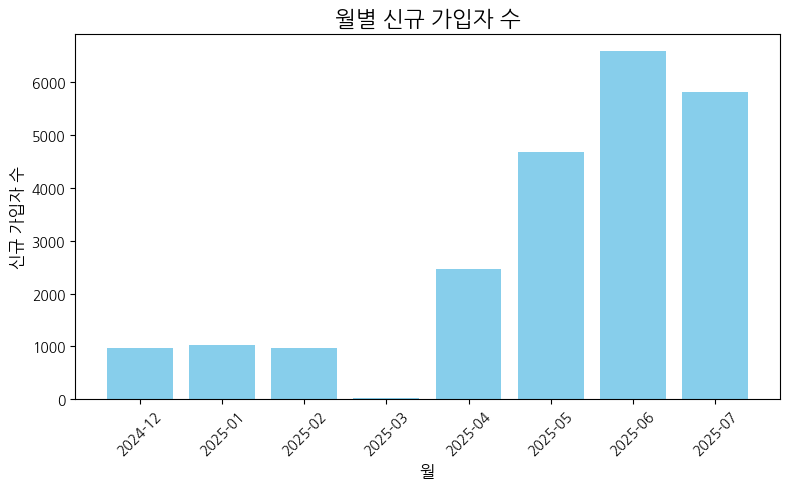

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib  # 한글 폰트 자동 적용

# 1. 일별 신규 가입자 수
daily_signups = (
    users.groupby(users['created_at'].dt.date)['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'created_at': 'date', 'user_id': 'new_users'})
)

# 2. 월별 신규 가입자 수
monthly_signups = (
    users.groupby(users['created_at'].dt.to_period('M'))['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'created_at': 'month', 'user_id': 'new_users'})
)

# # 3. 일별 그래프 > 보기 불편하서 주별로 다음 코드에서 수정
# # plt.figure(figsize=(12,5))
# # plt.plot(daily_signups['date'], daily_signups['new_users'], marker='o', linewidth=1)
# # plt.title("일별 신규 가입자 수 추이", fontsize=16)
# # plt.xlabel("날짜", fontsize=12)
# # plt.ylabel("신규 가입자 수", fontsize=12)
# # plt.grid(True, alpha=0.3)
# # plt.xticks(rotation=45)
# # plt.tight_layout()
# # plt.show()

# 4. 월별 그래프
plt.figure(figsize=(8,5))
plt.bar(monthly_signups['month'].astype(str), monthly_signups['new_users'], color='skyblue')
plt.title("월별 신규 가입자 수", fontsize=16)
plt.xlabel("월", fontsize=12)
plt.ylabel("신규 가입자 수", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


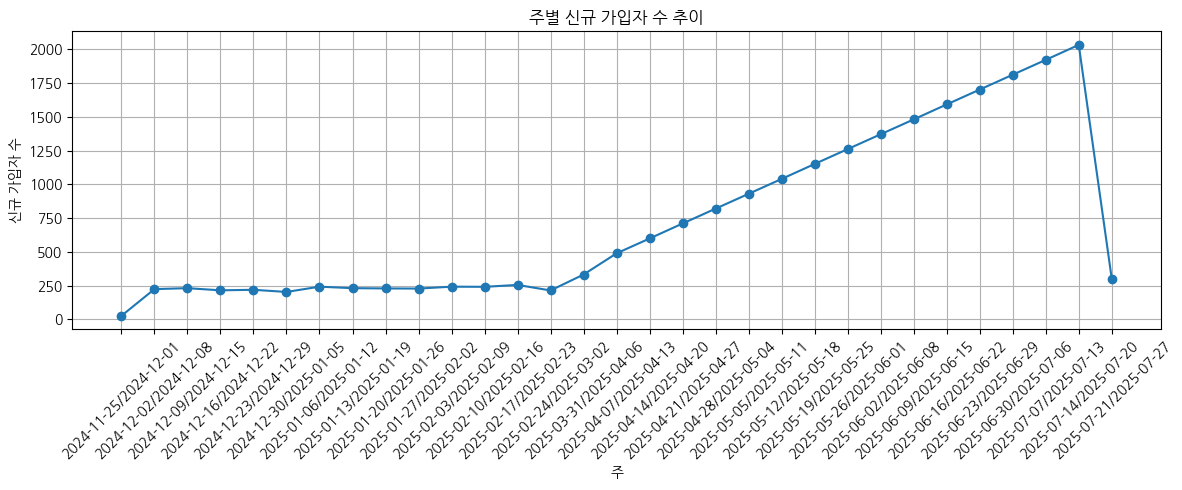

In [ ]:
#주별 가입자 수
weekly_signups = (
    users.groupby(users['created_at'].dt.to_period('W'))['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'created_at': 'week', 'user_id': 'new_users'})
)

plt.figure(figsize=(12,5))
plt.plot(weekly_signups['week'].astype(str), weekly_signups['new_users'], marker='o')
plt.title("주별 신규 가입자 수 추이")
plt.xlabel("주")
plt.ylabel("신규 가입자 수")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# 월별 신규 가입자 수 by df
monthly_signups = (
    users.groupby(users['created_at'].dt.to_period('M'))['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'created_at': 'month', 'user_id': 'new_users'})
)

# Period → 문자열 변환
monthly_signups['month'] = monthly_signups['month'].astype(str)

monthly_signups


,month,new_users
0,2024-12,976
1,2025-01,1018
2,2025-02,974
3,2025-03,32
4,2025-04,2468
5,2025-05,4677
6,2025-06,6585
7,2025-07,5815


In [ ]:
print(users['created_at'].min(), users['created_at'].max())


2024-12-01 00:36:00 2025-07-21 23:59:50


## 인사이트 도출
아주 잘 성장하고 있구만 ㅎㅎ

In [ ]:
campaigns.head()

,campaign_id,name,utm_source,utm_campaign
0,cmp_001,Spring Promo,facebook,spring24
1,cmp_002,Referral,referral,ref_buddy
2,cmp_003,Google CPC,google,sem24


In [ ]:
plan_history.value_counts()

,,,,,count
user_id,change_time,plan_name,plan_status,reason,
usr_fff254c46f6f,2025-06-24 00:00:00,annual_pro,canceled,user_canceled,1
usr_000d248833e6,2025-02-02 12:40:00,annual_pro,active,existing_user,1
usr_000e72325c7f,2025-07-05 00:00:00,annual_pro,active,trial_to_paid,1
usr_0014750e8701,2025-01-07 06:51:00,monthly_pro,canceled,existing_user,1
usr_001d27fb6e09,2025-07-03 00:00:00,annual_basic,active,trial_to_paid,1
...,...,...,...,...,...
usr_00626dfefcac,2024-12-15 13:56:00,monthly_basic,active,existing_user,1
usr_005853bff0c1,2025-07-08 00:00:00,annual_basic,active,trial_to_paid,1
usr_0056b3e1524e,2025-07-13 00:00:00,monthly_basic,active,trial_to_paid,1


## 고객 분석

### 1. 고객 이탈 가능성 분석

In [ ]:
# import pandas as pd
# import numpy as np
# from pathlib import Path

# # === 파라미터 / 상수 ===
# LESSON_EVENTS = {"lesson_played", "first_lesson_played"}
# DROP_RATIO_THRESHOLD = 0.5            # 베이스라인 대비 50% 미만
# MIN_WEEKS_BELOW_THRESHOLD = 2         # 조건 만족 주 최소 2주
# EVAL_WEEKS_FROM_BASELINE = None       # 예: 8 로 제한 가능 (없으면 전체)

# # === 출력 경로 (원하는 경로로 변경 가능) ===
# BASE = Path("/content/drive/MyDrive/project4/data")
# out1 = BASE / "interest_drop_users.csv"
# out2 = BASE / "interest_drop_weekly_counts_sample.csv"
# out3 = BASE / "interest_drop_users_baseline_debug.csv"

# # --------------------------
# # 1) 기본 전처리
# # --------------------------
# # event_timestamp를 반드시 datetime으로
# if "event_timestamp" in event_logs.columns:
#     event_logs["event_timestamp"] = pd.to_datetime(event_logs["event_timestamp"], errors="coerce")
# else:
#     raise ValueError("event_logs에 'event_timestamp' 컬럼이 필요합니다.")

# # created_at이 있으면 datetime 변환
# if "created_at" in users.columns:
#     users["created_at"] = pd.to_datetime(users["created_at"], errors="coerce")

# # --------------------------
# # 2) 수강 이벤트만 추출 → 주차 집계
# # --------------------------
# if "event_name" not in event_logs.columns:
#     raise ValueError("event_logs에 'event_name' 컬럼이 필요합니다.")

# lesson_df = event_logs[event_logs["event_name"].isin(LESSON_EVENTS)].copy()

# if lesson_df.empty:
#     print("※ lesson_played/first_lesson_played 이벤트가 없습니다. 분석을 종료합니다.")
#     # 필요하면 여기서 page_viewed 등 다른 소비 지표로 대체 가능
# else:
#     lesson_df["week"] = lesson_df["event_timestamp"].dt.to_period("W").apply(lambda r: r.start_time)
#     weekly_counts = (
#         lesson_df.groupby(["user_id", "week"], as_index=False)
#         .size()
#         .rename(columns={"size": "lesson_count"})
#     )

#     # --------------------------
#     # 3) 베이스라인(기준 주) 설정
#     #    - users.created_at 있으면 가입 주
#     #    - 없거나 전부 결측이면 각 유저의 '첫 수강 주'를 베이스라인으로
#     # --------------------------
#     users = users.copy()
#     baseline_from_created = False
#     if "created_at" in users.columns and users["created_at"].notna().any():
#         users["baseline_week"] = users["created_at"].dt.to_period("W").apply(lambda r: r.start_time)
#         baseline_from_created = True

#     if ("baseline_week" not in users.columns) or users["baseline_week"].isna().all():
#         # 첫 수강 주로 대체
#         first_weeks = (
#             weekly_counts.groupby("user_id")["week"]
#             .min()
#             .reset_index()
#             .rename(columns={"week": "baseline_week"})
#         )
#         users = users.drop(columns=[c for c in ["baseline_week"] if c in users.columns], errors="ignore")
#         users = users.merge(first_weeks, on="user_id", how="left")

#     # 주간 카운트와 baseline 병합
#     weekly_counts = weekly_counts.merge(users[["user_id", "baseline_week"]], on="user_id", how="left")

#     # baseline 주의 시청 횟수
#     baseline = weekly_counts[weekly_counts["week"] == weekly_counts["baseline_week"]][["user_id", "lesson_count"]]
#     baseline = baseline.rename(columns={"lesson_count": "baseline_count"})
#     weekly_counts = weekly_counts.merge(baseline, on="user_id", how="left")

#     # baseline_count 결측 → 유저의 첫 주 lesson_count로 대체
#     weekly_counts["baseline_count"] = weekly_counts["baseline_count"].fillna(
#         weekly_counts.groupby("user_id")["lesson_count"].transform("first")
#     )

#     # --------------------------
#     # 4) 변화율 / 관심사 고갈 플래그
#     # --------------------------
#     # 주차 차이(주 단위)
#     weekly_counts["week_num_from_baseline"] = (
#         (weekly_counts["week"] - weekly_counts["baseline_week"]).dt.days // 7
#     )

#     # 평가 기간 제한(옵션)
#     if EVAL_WEEKS_FROM_BASELINE is not None:
#         weekly_counts = weekly_counts[
#             (weekly_counts["week_num_from_baseline"] >= 0) &
#             (weekly_counts["week_num_from_baseline"] <= EVAL_WEEKS_FROM_BASELINE)
#         ]

#     # 변화율 (0 나눗셈 방지)
#     weekly_counts["change_ratio"] = np.where(
#         (weekly_counts["baseline_count"] > 0) & weekly_counts["baseline_count"].notna(),
#         weekly_counts["lesson_count"] / weekly_counts["baseline_count"],
#         np.nan
#     )

#     def interest_drop_flag(g: pd.DataFrame) -> bool:
#         # 기준 주 이후만 평가
#         g2 = g[g["week_num_from_baseline"] > 0]
#         if g2.empty:
#             return False
#         return (g2["change_ratio"] < DROP_RATIO_THRESHOLD).sum() >= MIN_WEEKS_BELOW_THRESHOLD

#     flag_df = (
#         weekly_counts.groupby("user_id")
#         .apply(interest_drop_flag)
#         .reset_index(name="interest_drop_flag")
#     )

#     # --------------------------
#     # 5) 보조 정보 병합: 현재 구독 상태, 마지막 해지 사유
#     # --------------------------
#     user_keep = [c for c in ["user_id", "plan_status", "subscription_plan"] if c in users.columns]
#     user_status = users[user_keep].drop_duplicates("user_id") if user_keep else pd.DataFrame(columns=["user_id"])

#     if "reason" in plan_history.columns:
#         sort_cols = ["user_id"] + (["change_time"] if "change_time" in plan_history.columns else [])
#         if "change_time" in plan_history.columns:
#             plan_history["change_time"] = pd.to_datetime(plan_history["change_time"], errors="coerce")
#         last_reason = (
#             plan_history.sort_values(sort_cols)
#             .groupby("user_id", as_index=False)
#             .last()[["user_id", "reason"]]
#         )
#     else:
#         last_reason = pd.DataFrame(columns=["user_id", "reason"])

#     result = flag_df.merge(user_status, on="user_id", how="left")
#     if not last_reason.empty:
#         result = result.merge(last_reason, on="user_id", how="left")

#     # --------------------------
#     # 6) 저장 및 요약
#     # --------------------------
#     # result.to_csv(out1, index=False, encoding="utf-8-sig")
#     # weekly_counts.sort_values(["user_id", "week"]).head(2000).to_csv(out2, index=False, encoding="utf-8-sig")
#     # users[["user_id", "baseline_week"] + [c for c in ["created_at"] if c in users.columns]].to_csv(out3, index=False, encoding="utf-8-sig")

#     print("\n=== 요약 지표 ===")
#     print("관심사 고갈 의심 유저 수:", int(result["interest_drop_flag"].sum()))
#     print("총 유저 수:", int(result["user_id"].nunique()))
#     print(f"- 결과: {out1.name}")
#     print(f"- 샘플 주간수: {out2.name}")
#     print(f"- 기준주 디버그: {out3.name}")

#     if baseline_from_created:
#         print("※ 베이스라인: users.created_at 기준")
#     else:
#         print("※ 베이스라인: 각 유저의 첫 수강 주 기준")



In [ ]:
# === 요약 지표 ===
# 관심사 고갈 의심 유저 수: 1846
# 총 유저 수: 20676
# - 결과: interest_drop_users.csv
# - 샘플 주간수: interest_drop_weekly_counts_sample.csv
# - 기준주 디버그: interest_drop_users_baseline_debug.csv
# ※ 베이스라인: users.created_at 기준

### 문제점 파악을 위한 EDA

In [ ]:
campaigns.head()

,campaign_id,name,utm_source,utm_campaign
0,cmp_001,Spring Promo,facebook,spring24
1,cmp_002,Referral,referral,ref_buddy
2,cmp_003,Google CPC,google,sem24


In [ ]:
referral_events.head()

,referrer_user_id,referred_user_id,referral_time,referral_code
0,usr_6b87a57bd775,usr_999627af31c9,2025-01-03 07:00:00,rf_2dc98f20
1,usr_065a57484a03,usr_97c482c5ea09,2024-12-04 19:23:00,rf_323a083c
2,usr_b783533a534b,usr_039406094001,2025-01-14 15:12:00,rf_9b6ed228
3,usr_999627af31c9,usr_baae86ef556b,2025-02-15 11:50:00,rf_50e5a02d
4,usr_2b0c7bbc467f,usr_2752111a2aa5,2024-12-22 02:32:00,rf_86fb7f63


In [ ]:
push_events.head()

,push_id,user_id,sent_at,opened,push_type
0,push_c0fa6339,usr_d2d410ce462c,2025-04-01 19:49:34,True,promotion
1,push_c596b41f,usr_1e61c54ffe43,2025-04-01 21:37:44,False,reminder
2,push_cc6496a2,usr_bc37c1c9df4a,2025-04-01 04:00:29,False,reminder
3,push_a32df886,usr_eaf94e026f0e,2025-04-01 11:16:08,False,reminder
4,push_6186b3a8,usr_e18d3381a0a4,2025-04-01 16:42:10,True,system


In [ ]:
referral_events.head()

,referrer_user_id,referred_user_id,referral_time,referral_code
0,usr_6b87a57bd775,usr_999627af31c9,2025-01-03 07:00:00,rf_2dc98f20
1,usr_065a57484a03,usr_97c482c5ea09,2024-12-04 19:23:00,rf_323a083c
2,usr_b783533a534b,usr_039406094001,2025-01-14 15:12:00,rf_9b6ed228
3,usr_999627af31c9,usr_baae86ef556b,2025-02-15 11:50:00,rf_50e5a02d
4,usr_2b0c7bbc467f,usr_2752111a2aa5,2024-12-22 02:32:00,rf_86fb7f63


In [ ]:
users.head()

# campaign_id = 내부 시스템에서 관리하는 캠페인 식별자
# utm_source = 그 캠페인의 유입 채널
# utm_campaign = 그 캠페인의 이름(프로모션 코드)

,user_id,created_at,last_seen_at,email,acquisition_source,subscription_plan,plan_status,device_type,plan_start_date,plan_end_date,gender,age_group,age,campaign_id,utm_source,utm_campaign
0,usr_6b87a57bd775,2025-02-09 12:50:00,2025-07-09 00:05:00,jinhyeonu@example.net,referral,none,none,web,NaN,NaN,M,30s,39,cmp_003,google,sem24
1,usr_b95ee57a273a,2024-12-09 20:57:00,2025-07-19 09:29:00,wgim@example.com,referral,annual_pro,active,android,2024-12-16 20:57:00,NaN,M,30s,35,cmp_001,facebook,spring24
2,usr_fc7ffc4130f7,2025-01-07 02:18:00,2025-07-20 12:57:00,coejaeho@example.com,facebook_ads,monthly_pro,active,ios,2025-05-16,NaN,M,10s,16,cmp_003,google,sem24
3,usr_f0dbe9c02021,2025-01-25 11:14:00,2025-07-09 03:16:00,ngim@example.com,google_cpc,monthly_pro,active,android,2025-01-26 11:14:00,NaN,F,40s,48,cmp_001,facebook,spring24
4,usr_6f08473e5134,2025-01-30 02:22:00,2025-07-03 02:55:00,gimujin@example.com,direct,none,none,android,NaN,NaN,M,30s,31,cmp_001,facebook,spring24


In [ ]:
users['utm_campaign'].value_counts()

,count
utm_campaign,
sem24,7672
spring24,7441
ref_buddy,7432


<Axes: ylabel='count'>

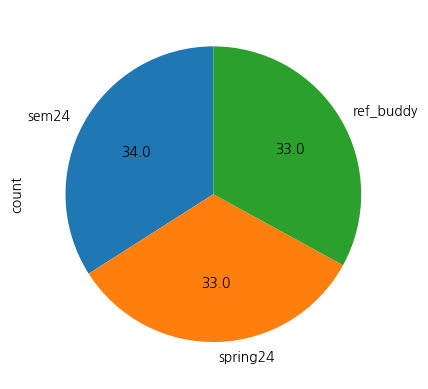

In [ ]:
users['utm_campaign'].value_counts().plot.pie(autopct='%0.1f',startangle=90)

# 봄 시즌 한정 프로모션
# 추천인(친구 초대) 캠페인
# 구글 검색광고(Click Per Cost) 캠페인

<Axes: ylabel='count'>

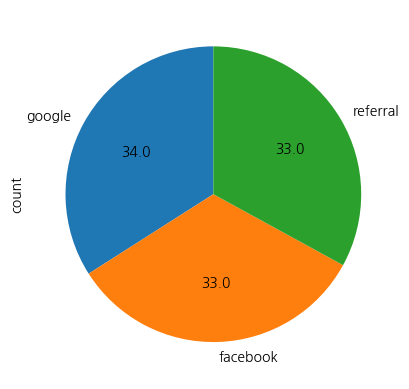

In [ ]:
users['utm_source'].value_counts().plot.pie(autopct='%0.1f',startangle=90)


In [ ]:
import pandas as pd

# CSV 불러오기
payment_transactions = pd.read_csv("/content/drive/MyDrive/project4/data/payment_transactions.csv")

# 1. 성공 결제만 필터링
success_payments = payment_transactions[payment_transactions["status"] == "success"]

# 2. 유저별 총 지출 계산
user_spending = success_payments.groupby("user_id")["amount"].sum()

# 3. 평균 지출 금액 계산
avg_spending = user_spending.mean()

print(f"고객 1인당 평균 지출 금액: {avg_spending:.2f} 달러")


고객 1인당 평균 지출 금액: 81.63 달러


# 문의 유형별 처리상태 , 감정 분석

## 처리상태 분석

In [ ]:
chat_events.head()

,chat_id,user_id,sent_at,tag,emotion,channel,status
0,chat_d678903d6e,usr_d9957640e673,2025-04-01 12:39:32,Error,negative,web,open
1,chat_a4a7c3a003,usr_53edf6429808,2025-04-01 13:59:07,Other,negative,in_app,in_progress
2,chat_086533804d,usr_b3b6d07c5a6a,2025-04-01 10:48:29,Feature Suggestion,neutral,email,in_progress
3,chat_a52fea733c,usr_f14a5d9a25cc,2025-04-01 03:58:33,Other,neutral,in_app,in_progress
4,chat_f84a34f30f,usr_a933fb6930fa,2025-04-01 04:11:18,Learning,neutral,in_app,in_progress


In [ ]:
!pip install koreanize_matplotlib

=== 문의 유형별 처리 상태 (롱포맷) ===
                   tag       status  count
0              Account       closed     76
1              Account  in_progress     73
3              Account     resolved     73
2              Account         open     71
7            Complaint     resolved     88
5            Complaint  in_progress     75
6            Complaint         open     72
4            Complaint       closed     58
10               Error         open     69
9                Error  in_progress     65
8                Error       closed     57
11               Error     resolved     57
12  Feature Suggestion       closed     73
13  Feature Suggestion  in_progress     70
15  Feature Suggestion     resolved     62
14  Feature Suggestion         open     56
18            Learning         open     72
16            Learning       closed     59
19            Learning     resolved     56
17            Learning  in_progress     54

=== 문의 유형별 처리 상태 (피벗/건수) ===
status              open  in_progress  r

<Figure size 1000x600 with 0 Axes>

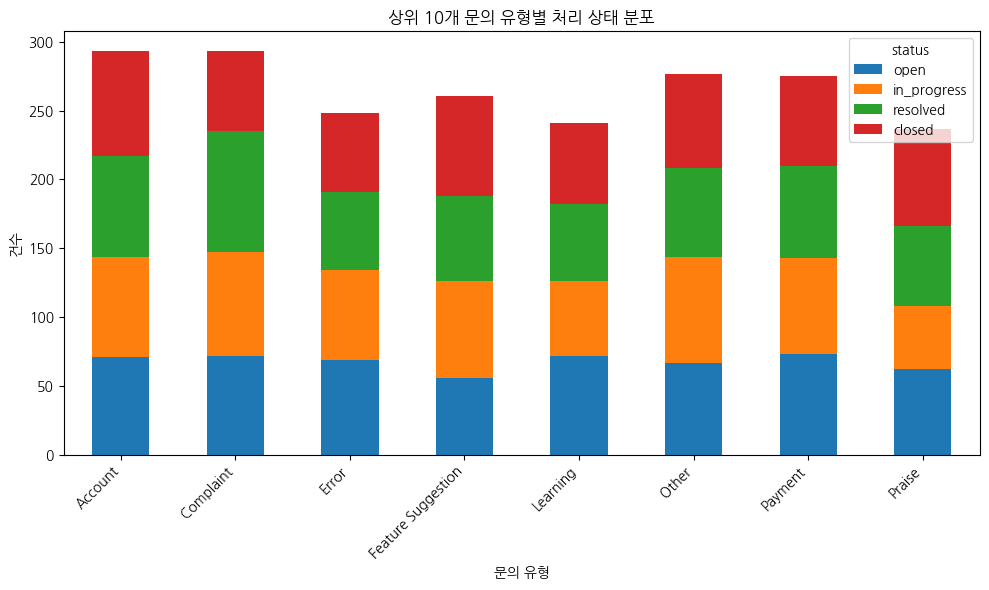

In [ ]:
# 문의 유형별 처리상태
import pandas as pd

# 0) 전처리: 태그 결측치 처리
chat_tmp = chat_events.copy()
chat_tmp['tag'] = chat_tmp['tag'].fillna('미지정')

# 1) 문의 유형(tag) x 처리 상태(status) 건수 테이블 (긴 형식)
tag_status_counts = (
    chat_tmp
    .groupby(['tag', 'status'], as_index=False)
    .size()
    .rename(columns={'size': 'count'})
    .sort_values(['tag', 'count'], ascending=[True, False])
)

print("=== 문의 유형별 처리 상태 (롱포맷) ===")
print(tag_status_counts.head(20))  # 상위 20행만 확인

# 2) 피벗: 행=tag, 열=status → 건수 매트릭스
status_order = ['open', 'in_progress', 'resolved', 'closed']
tag_status_pivot = (
    tag_status_counts
    .pivot(index='tag', columns='status', values='count')
    .fillna(0)
    .astype(int)
    .reindex(columns=[c for c in status_order if c in tag_status_counts['status'].unique()], fill_value=0)
)

print("\n=== 문의 유형별 처리 상태 (피벗/건수) ===")
print(tag_status_pivot.head(10))

# 3) 문의 유형 내 비율(= 각 tag 행 합으로 나눈 비율)
tag_row_sum = tag_status_pivot.sum(axis=1).replace(0, pd.NA)
tag_status_ratio = (tag_status_pivot.div(tag_row_sum, axis=0) * 100).round(1)

print("\n=== 문의 유형별 처리 상태 비율(%) ===")
print(tag_status_ratio.head(10))


# 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib  # 한글 폰트 적용

# NaN 태그 처리
chat_tmp = chat_events.copy()
chat_tmp['tag'] = chat_tmp['tag'].fillna('미지정')

# 상위 10개 태그만
top_tags = chat_tmp['tag'].value_counts().head(10).index
tag_top = chat_tmp[chat_tmp['tag'].isin(top_tags)]

# 교차표 생성
status_order = ['open', 'in_progress', 'resolved', 'closed']
ct_tag_status = pd.crosstab(tag_top['tag'], tag_top['status'])
ct_tag_status = ct_tag_status[[c for c in status_order if c in ct_tag_status.columns]]

# 시각화
plt.figure(figsize=(10,6))
ct_tag_status.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('상위 10개 문의 유형별 처리 상태 분포')
plt.xlabel('문의 유형')
plt.ylabel('건수')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# CSV 저장
tag_status_pivot.to_csv("문의유형별_처리상태_피벗.csv", encoding="utf-8-sig")
tag_status_counts.to_csv("문의유형별_처리상태.csv", index=False, encoding="utf-8-sig")

<Axes: xlabel='tag'>

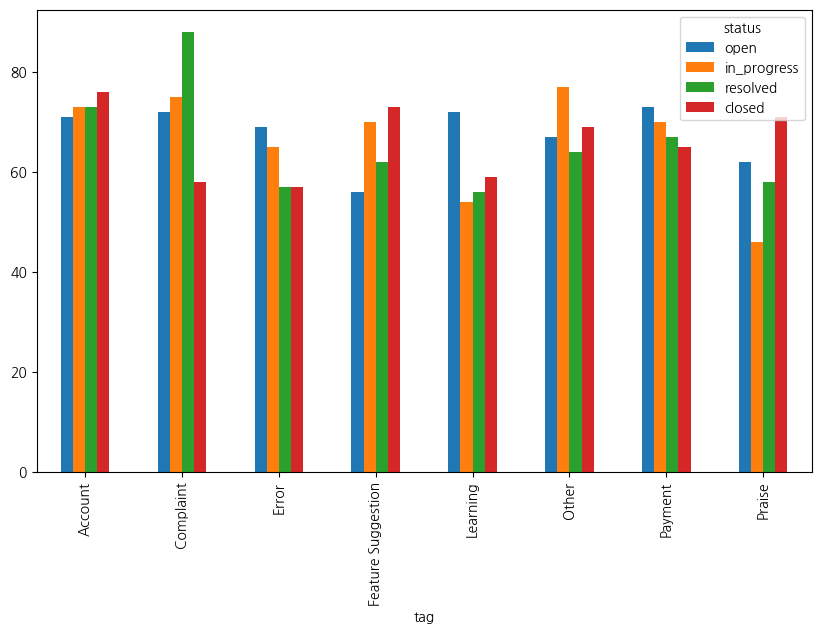

In [ ]:
# 보기 불편해 다른 방식의 시각
ct_tag_status.plot(kind='bar', stacked=False, figsize=(10,6))


In [ ]:
chat_events['tag'].value_counts()

,count
tag,
Complaint,293
Account,293
Other,277
Payment,275
Feature Suggestion,261
Error,248
Learning,241
Praise,237


In [ ]:
# import matplotlib.pyplot as plt
# import koreanize_matplotlib

# plt.figure(figsize=(7,5))
# bars = plt.bar(top_tag_per_status_df['status'],
#                top_tag_per_status_df['count'],
#                color='skyblue')

# for i, (cnt, tag) in enumerate(zip(top_tag_per_status_df['count'], top_tag_per_status_df['tag'])):
#     # 첫 줄: 태그명, 두 번째 줄: 건수
#     plt.text(i, cnt + 2, f"{tag}", ha='center', va='bottom', fontsize=10)
#     plt.text(i, cnt - 5, f"{cnt}건", ha='center', va='bottom', fontsize=9, color='black')

# plt.title("각 상태별 최다 문의 유형")
# plt.xlabel("처리 상태")
# plt.ylabel("건수")
# plt.ylim(0, top_tag_per_status_df['count'].max() + 15)  # 여유 공간 확보
# plt.tight_layout()
# plt.show()


                  tag       status  count
0             Account       closed     76
1           Complaint     resolved     88
2               Error         open     69
3  Feature Suggestion       closed     73
4            Learning         open     72
5               Other  in_progress     77
6             Payment         open     73
7              Praise       closed     71


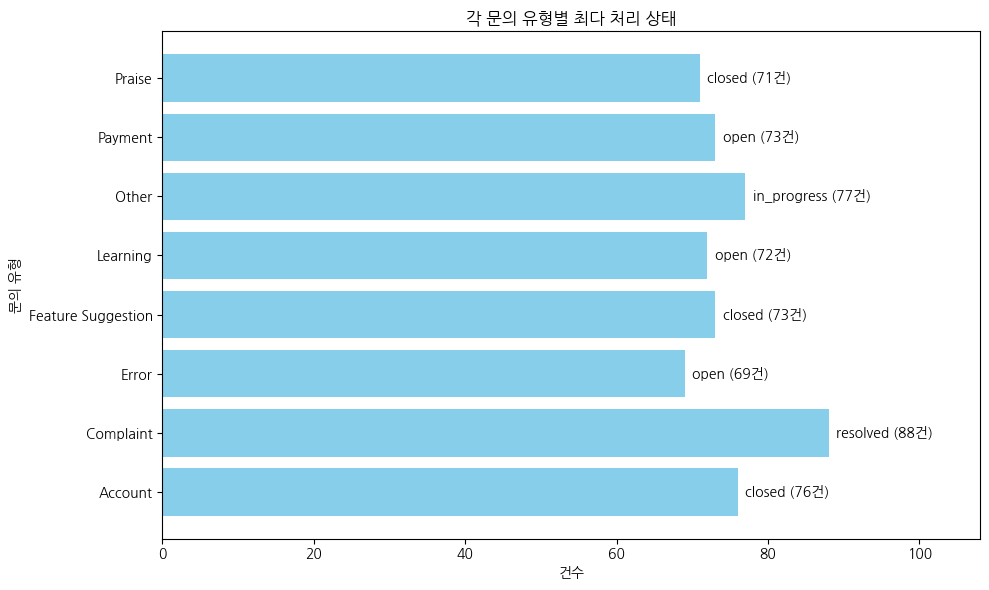

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

# NaN 태그 처리
chat_tmp = chat_events.copy()
chat_tmp['tag'] = chat_tmp['tag'].fillna('미지정')

# 각 tag별 최다 상태 구하기
top_status_per_tag = (
    chat_tmp
    .groupby(['tag', 'status'], as_index=False)
    .size()
    .rename(columns={'size': 'count'})
    .sort_values(['tag', 'count'], ascending=[True, False])
    .groupby('tag')  # 태그별로
    .head(1)         # 최다 상태 1개만 선택
    .reset_index(drop=True)
)

print(top_status_per_tag)

# 시각화 (가로 막대)
plt.figure(figsize=(10,6))
bars = plt.barh(top_status_per_tag['tag'], top_status_per_tag['count'], color='skyblue')

# 바에 텍스트 표시 (상태 + 건수)
for bar, status, count in zip(bars, top_status_per_tag['status'], top_status_per_tag['count']):
    plt.text(bar.get_width() + 1,
             bar.get_y() + bar.get_height()/2,
             f"{status} ({count}건)",
             va='center', fontsize=10)

plt.title("각 문의 유형별 최다 처리 상태")
plt.xlabel("건수")
plt.ylabel("문의 유형")
plt.xlim(0, top_status_per_tag['count'].max() + 20)  # 여유 공간 확보
plt.tight_layout()
plt.show()


## 감정분석

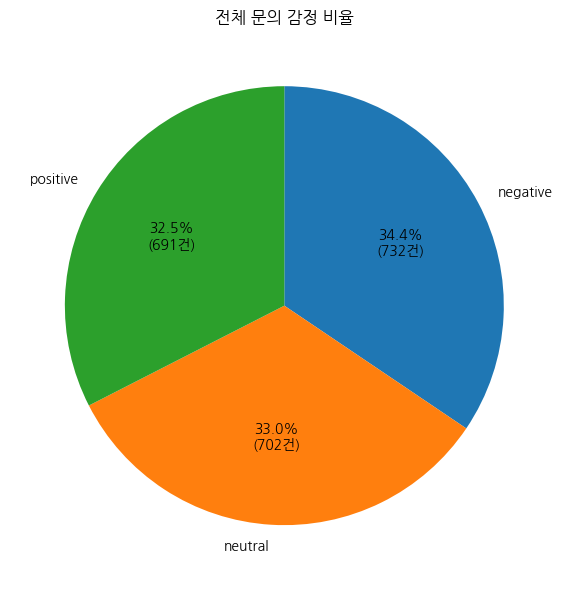

In [ ]:
# 전체 감정 분포
import matplotlib.pyplot as plt
import koreanize_matplotlib  # 한글 폰트 적용

# 1) 감정 분포 집계
emotion_counts = chat_events['emotion'].value_counts()
total = int(emotion_counts.sum())

# 2) 파이차트
plt.figure(figsize=(6,6))
plt.pie(
    emotion_counts.values,
    labels=emotion_counts.index,
    autopct=lambda p: f'{p:.1f}%\n({int(round(p*total/100))}건)',
    startangle=90,
    counterclock=False,
    textprops={'fontsize':10}
)
plt.title('전체 문의 감정 비율')
plt.tight_layout()
plt.show()


=== 처리 상태 × 감정 (건수) ===
emotion      negative  neutral  positive
status                                  
open              201      178       163
in_progress       179      164       187
resolved          180      177       168
closed            172      183       173

=== 처리 상태 × 감정 (비율 %) ===
emotion      negative  neutral  positive
status                                  
open             37.1     32.8      30.1
in_progress      33.8     30.9      35.3
resolved         34.3     33.7      32.0
closed           32.6     34.7      32.8


<Figure size 900x500 with 0 Axes>

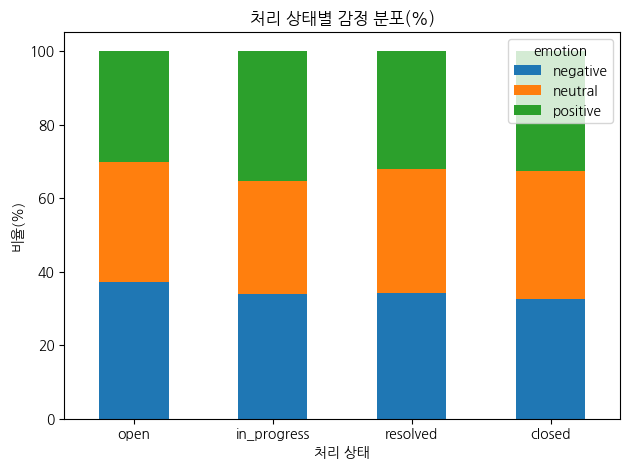

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib  # 한글 폰트 적용

# 1) 교차표 (건수)
status_order = ['open', 'in_progress', 'resolved', 'closed']
ct = pd.crosstab(chat_events['status'], chat_events['emotion'])

# 상태 순서 정리(있는 것만 반영)
ct = ct.reindex([s for s in status_order if s in ct.index])

print("=== 처리 상태 × 감정 (건수) ===")
print(ct)

# 2) 상태별 감정 비율(%) 계산
ratio = (ct.div(ct.sum(axis=1), axis=0) * 100).round(1)

print("\n=== 처리 상태 × 감정 (비율 %) ===")
print(ratio)

# 3) 시각화: 상태별 감정 비율(%) - 스택형 막대 (단 하나)
plt.figure(figsize=(9,5))
ratio.plot(kind='bar', stacked=True)
plt.title('처리 상태별 감정 분포(%)')
plt.xlabel('처리 상태')
plt.ylabel('비율(%)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


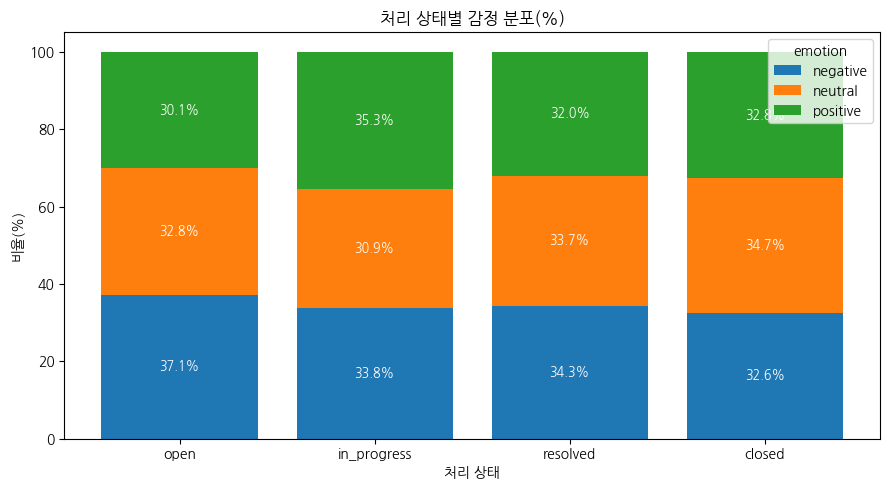

In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 교차표 및 비율 계산
status_order = ['open', 'in_progress', 'resolved', 'closed']
ct = pd.crosstab(chat_events['status'], chat_events['emotion'])
ct = ct.reindex([s for s in status_order if s in ct.index])
ratio = (ct.div(ct.sum(axis=1), axis=0) * 100).round(1)

# 스택형 막대 시각화
fig, ax = plt.subplots(figsize=(9,5))
bottom_val = [0] * len(ratio)

for emotion in ratio.columns:
    ax.bar(ratio.index, ratio[emotion], bottom=bottom_val, label=emotion)
    # 비율 값 표시
    for i, val in enumerate(ratio[emotion]):
        if val > 0:  # 0%는 표시 안 함
            ax.text(i, bottom_val[i] + val/2, f"{val}%",
                    ha='center', va='center', fontsize=9, color='white')
    bottom_val = [bottom_val[j] + ratio[emotion].iloc[j] for j in range(len(ratio))]

ax.set_title('처리 상태별 감정 분포(%)')
ax.set_xlabel('처리 상태')
ax.set_ylabel('비율(%)')
ax.legend(title='emotion')
plt.tight_layout()
plt.show()


## 감정분석 결론
분석결과 지금 상태로는 의미 있는 인사이트 도출이 힘들어 보임  
 > 기간별 감정분석으로 넘어감

## 감정분석2(기간별)

### 월별 감정 비율 분석

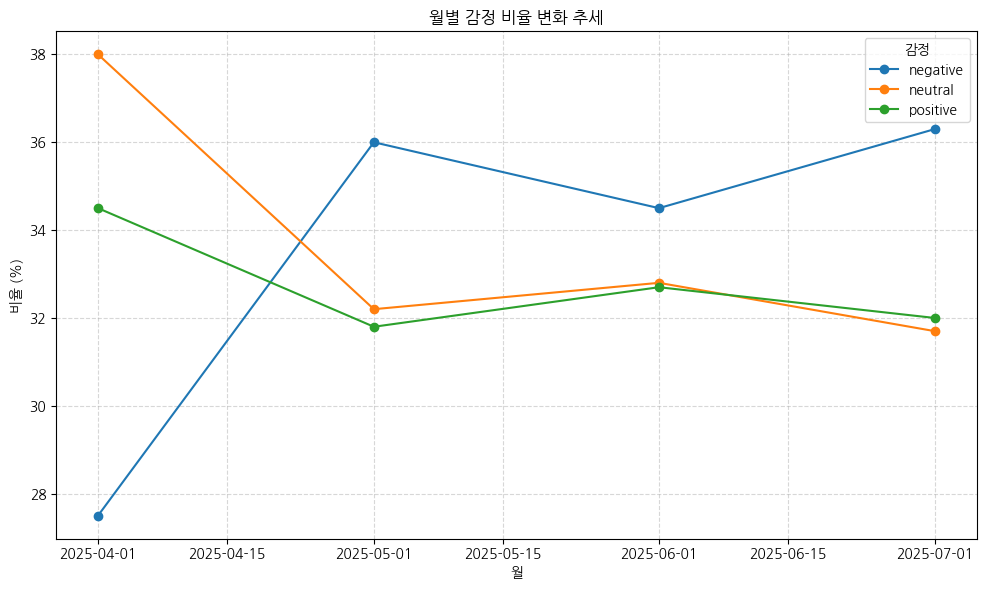

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 1) sent_at을 datetime으로 변환
chat_events['sent_at'] = pd.to_datetime(chat_events['sent_at'])

# 2) 월 단위 컬럼 생성
chat_events['month'] = chat_events['sent_at'].dt.to_period('M').dt.to_timestamp()

# 3) 월별 감정 비율 집계
monthly_emotion = (
    chat_events
    .groupby(['month', 'emotion'])
    .size()
    .reset_index(name='count')
)

# 총합 대비 비율 계산
monthly_total = monthly_emotion.groupby('month')['count'].transform('sum')
monthly_emotion['ratio'] = (monthly_emotion['count'] / monthly_total * 100).round(1)

# 4) 피벗 (행=월, 열=emotion, 값=비율)
monthly_emotion_pivot = monthly_emotion.pivot(index='month', columns='emotion', values='ratio').fillna(0)

# 5) 시각화
plt.figure(figsize=(10,6))
for col in monthly_emotion_pivot.columns:
    plt.plot(monthly_emotion_pivot.index, monthly_emotion_pivot[col], marker='o', label=col)

plt.title('월별 감정 비율 변화 추세')
plt.xlabel('월')
plt.ylabel('비율 (%)')
plt.legend(title='감정')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
chat_events['sent_at'].max()

Timestamp('2025-07-21 23:46:40')

In [ ]:
chat_events['sent_at'].min()

Timestamp('2025-04-01 03:58:33')

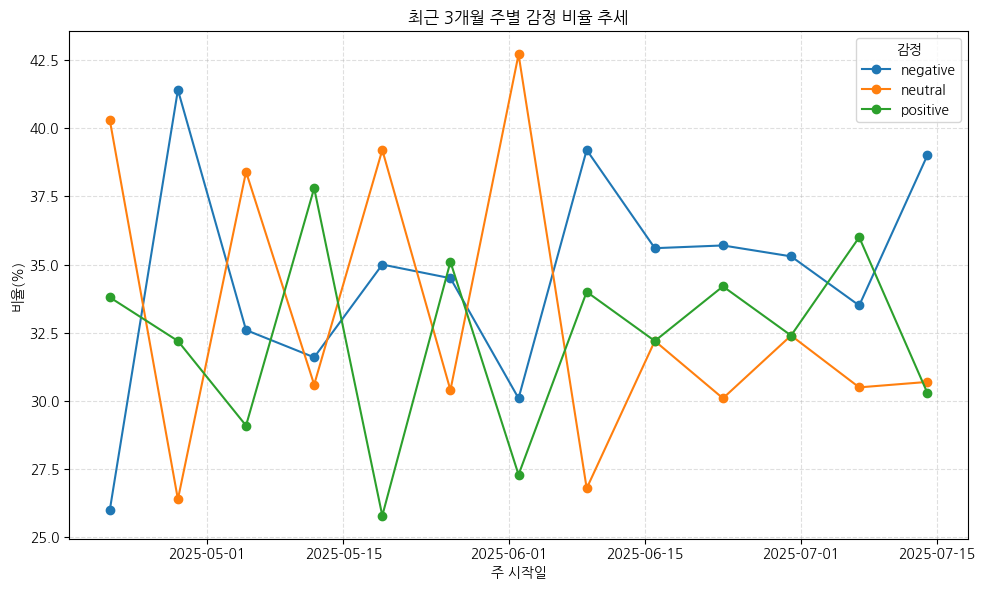

In [ ]:
# 최근 상태 분석
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib  # 한글 폰트

# 1) 날짜 변환
chat_events['sent_at'] = pd.to_datetime(chat_events['sent_at'])

# 2) 분석 기간: 데이터 최대일 기준 최근 3개월
end_dt = chat_events['sent_at'].max().normalize()
start_dt = end_dt - pd.DateOffset(months=3)
df = chat_events[(chat_events['sent_at'] >= start_dt) & (chat_events['sent_at'] <= end_dt)].copy()

# 3) 주(week) 단위 컬럼 (Period->주 시작일 Timestamp)
df['week'] = df['sent_at'].dt.to_period('W').apply(lambda r: r.start_time)

# 4) 주별 감정 비율 집계
weekly_emotion = (
    df.groupby(['week', 'emotion'])
      .size()
      .reset_index(name='count')
)
weekly_emotion['ratio'] = (
    weekly_emotion['count'] /
    weekly_emotion.groupby('week')['count'].transform('sum') * 100
).round(1)

# 5) 피벗: 행=주, 열=감정, 값=비율(%)
weekly_pivot = weekly_emotion.pivot(index='week', columns='emotion', values='ratio').fillna(0)

# 6) 시각화
plt.figure(figsize=(10,6))
for col in weekly_pivot.columns:
    plt.plot(weekly_pivot.index, weekly_pivot[col], marker='o', label=col)

plt.title('최근 3개월 주별 감정 비율 추세')
plt.xlabel('주 시작일')
plt.ylabel('비율(%)')
plt.legend(title='감정')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import koreanize_matplotlib

# # 1) sent_at datetime 변환
# chat_events['sent_at'] = pd.to_datetime(chat_events['sent_at'])

# # 2) 월 컬럼 생성
# chat_events['month'] = chat_events['sent_at'].dt.to_period('M').dt.to_timestamp()

# # 3) 월 × 상태 × 감정 집계
# monthly_status_emotion = (
#     chat_events
#     .groupby(['month', 'status', 'emotion'])
#     .size()
#     .reset_index(name='count')
# )

# # 4) 상태별 총합 대비 비율 계산
# monthly_status_total = monthly_status_emotion.groupby(['month', 'status'])['count'].transform('sum')
# monthly_status_emotion['ratio'] = (monthly_status_emotion['count'] / monthly_status_total * 100).round(1)

# # 5) 시각화: 상태별 서브플롯 (시계열)
# statuses = monthly_status_emotion['status'].unique()
# fig, axes = plt.subplots(len(statuses), 1, figsize=(10, 6), sharex=True)

# for i, status in enumerate(statuses):
#     subset = monthly_status_emotion[monthly_status_emotion['status'] == status]
#     pivot_data = subset.pivot(index='month', columns='emotion', values='ratio').fillna(0)
#     pivot_data.plot(ax=axes[i], marker='o')
#     axes[i].set_title(f"{status} 상태의 월별 감정 비율 추세")
#     axes[i].set_ylabel('비율(%)')
#     axes[i].legend(title='감정')

# plt.xlabel('월')
# plt.tight_layout()
# plt.show()



### 월별 네거티브 건수 , 컴플레인 건수 교차 비교



       month  negative_count  complaint_count
0 2025-04-01              78               32
1 2025-05-01             177               77
2 2025-06-01             247               97
3 2025-07-01             230               87


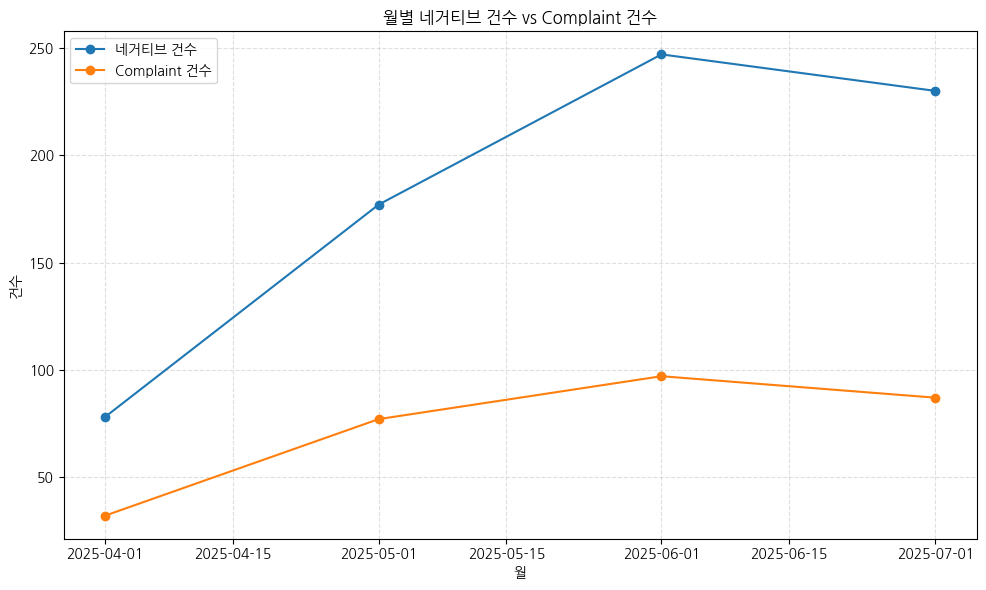

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib  # 한글 폰트

# 1) 월 컬럼
chat_events['sent_at'] = pd.to_datetime(chat_events['sent_at'])
chat_events['month'] = chat_events['sent_at'].dt.to_period('M').dt.to_timestamp()

# 2) 월별 negative 건수
neg_m = (
    chat_events[chat_events['emotion'] == 'negative']
    .groupby('month').size()
    .reset_index(name='negative_count')
)

# 3) 월별 Complaint(문의 유형) 건수
comp_m = (
    chat_events[chat_events['tag'] == 'Complaint']
    .groupby('month').size()
    .reset_index(name='complaint_count')
)

# 4) 병합 (월 기준)
monthly_cmp = pd.merge(neg_m, comp_m, on='month', how='outer').fillna(0)
monthly_cmp = monthly_cmp.sort_values('month')

print(monthly_cmp)

# 5) 시각화: 두 라인을 한 축에
plt.figure(figsize=(10,6))
plt.plot(monthly_cmp['month'], monthly_cmp['negative_count'], marker='o', label='네거티브 건수')
plt.plot(monthly_cmp['month'], monthly_cmp['complaint_count'], marker='o', label='Complaint 건수')

plt.title('월별 네거티브 건수 vs Complaint 건수')
plt.xlabel('월')
plt.ylabel('건수')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### 신규 모집 인원수까지 포함한 시각화 그래프


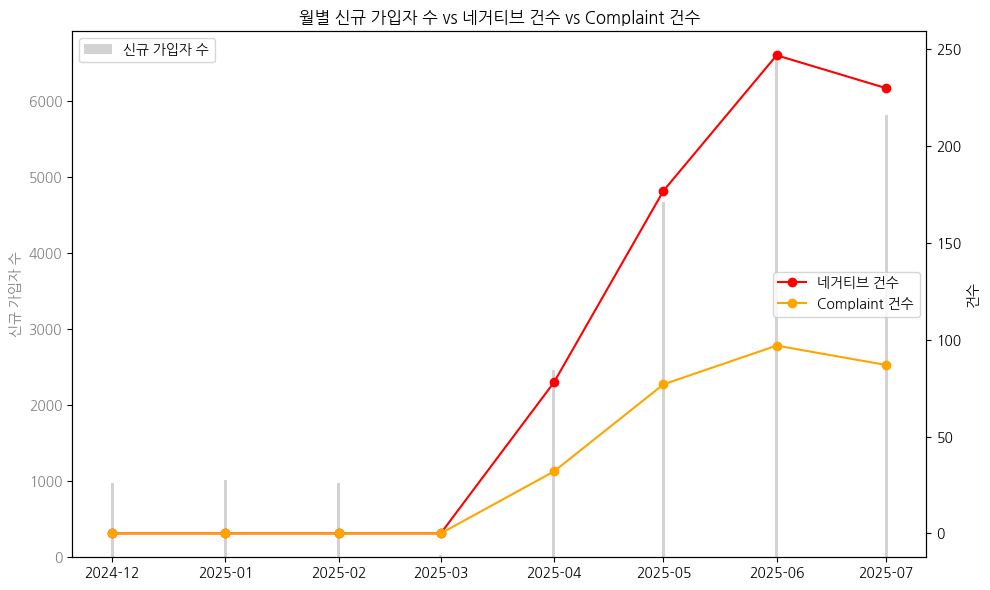

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 1) users 테이블 → 월별 신규 가입자 수
users['created_at'] = pd.to_datetime(users['created_at'])
users['month'] = users['created_at'].dt.to_period('M').dt.to_timestamp()

monthly_new_users = (
    users.groupby('month')
    .size()
    .reset_index(name='new_users')
)

# 2) chat_events 테이블 → 월별 negative 건수
chat_events['sent_at'] = pd.to_datetime(chat_events['sent_at'])
chat_events['month'] = chat_events['sent_at'].dt.to_period('M').dt.to_timestamp()

neg_m = (
    chat_events[chat_events['emotion'] == 'negative']
    .groupby('month').size()
    .reset_index(name='negative_count')
)

# 3) chat_events 테이블 → 월별 Complaint 건수
comp_m = (
    chat_events[chat_events['tag'] == 'Complaint']
    .groupby('month').size()
    .reset_index(name='complaint_count')
)

# 4) 세 데이터 병합
merged_df = monthly_new_users.merge(neg_m, on='month', how='left').merge(comp_m, on='month', how='left').fillna(0)

# 5) 시각화

# 범례 위치 조정 버전
fig, ax1 = plt.subplots(figsize=(10,6))

# 신규 가입자 막대
ax1.bar(merged_df['month'], merged_df['new_users'], color='lightgray', label='신규 가입자 수')
ax1.set_ylabel('신규 가입자 수', color='gray')
ax1.tick_params(axis='y', labelcolor='gray')

# 네거티브 & Complaint 선
ax2 = ax1.twinx()
ax2.plot(merged_df['month'], merged_df['negative_count'], marker='o', color='red', label='네거티브 건수')
ax2.plot(merged_df['month'], merged_df['complaint_count'], marker='o', color='orange', label='Complaint 건수')
ax2.set_ylabel('건수', color='black')
ax2.tick_params(axis='y', labelcolor='black')

plt.title('월별 신규 가입자 수 vs 네거티브 건수 vs Complaint 건수')

# 범례 위치 변경
ax1.legend(loc='upper left')  # 신규 가입자 수 범례는 왼쪽 위
ax2.legend(loc='center right')  # 네거티브/Complaint 범례는 오른쪽 중앙

plt.tight_layout()
plt.show()



## 인사이트
목적  
* 더 나은 서비스 제공과 고객 만족도 개선을 위한 데이터 분석

방법 1: 문의 유형별 처리 상태 x 감정 분석  
* 결과: 문의 유형별·감정별 비율이 전반적으로 균등하게 분포
* 해석: 특정 유형·감정에서 두드러진 편차가 없어, 현재 데이터로는 개선 포인트 식별 어려움

  
방법 2: 기간별(월별) 감정 비율 분석
* 결과: 부정 감정(negative) 비율이 점진적으로 증가하는 추세 확인
* 가정: 신규 고객이 늘어나면서 부정 감정을 가진 사람의 절대 건수도 증가했을 것
* 증명:
  * 월별 신규 가입자 수와 negative 건수를 비교한 결과, 두 지표가 유사한 증가 패턴을 보임
  * Complaint 건수 역시 같은 흐름 → 신규 고객 증가에 따른 자연스러운 부정/불만 건수 증가로 해석 가능  
* 보완 필요: 비율 증가의 원인이 신규 고객 때문인지, 기존 고객 감정 변화 때문인지는 추가 분석 필요  
(예: 신규 vs 기존 고객 그룹별 감정 비율 비교)




### 월별 감정 비율 분석(처리 상태, 문의 유형별)

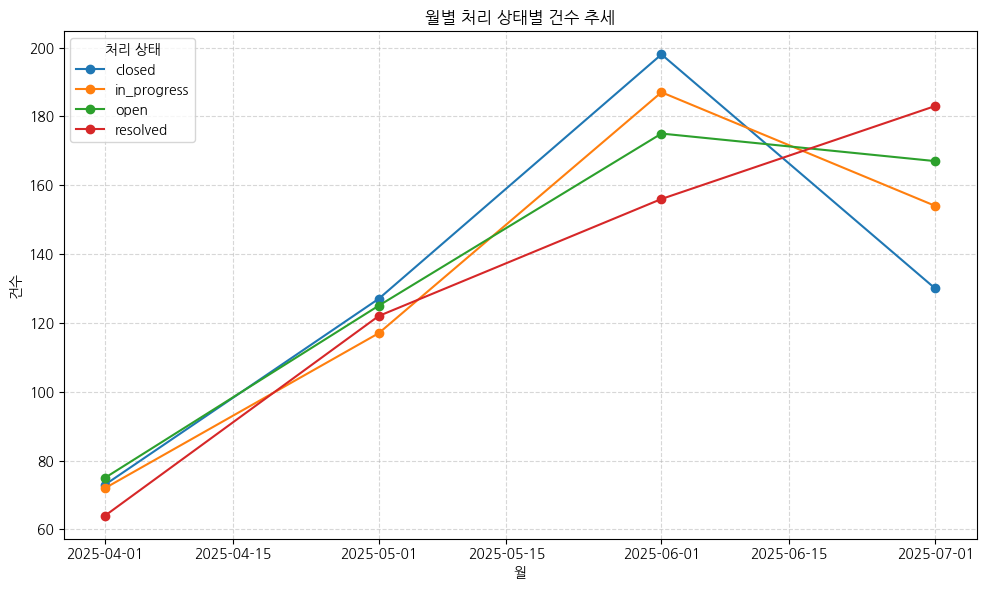

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 1) 날짜 변환 + 월 컬럼 생성
chat_events['sent_at'] = pd.to_datetime(chat_events['sent_at'])
chat_events['month'] = chat_events['sent_at'].dt.to_period('M').dt.to_timestamp()

# 2) 월 × 상태별 건수 집계
monthly_status = (
    chat_events
    .groupby(['month', 'status'])
    .size()
    .reset_index(name='count')
)

# 3) 피벗 (행=month, 열=status, 값=count)
monthly_status_pivot = monthly_status.pivot(index='month', columns='status', values='count').fillna(0)

# 4) 시각화
plt.figure(figsize=(10,6))
for col in monthly_status_pivot.columns:
    plt.plot(monthly_status_pivot.index, monthly_status_pivot[col], marker='o', label=col)

plt.title('월별 처리 상태별 건수 추세')
plt.xlabel('월')
plt.ylabel('건수')
plt.legend(title='처리 상태')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


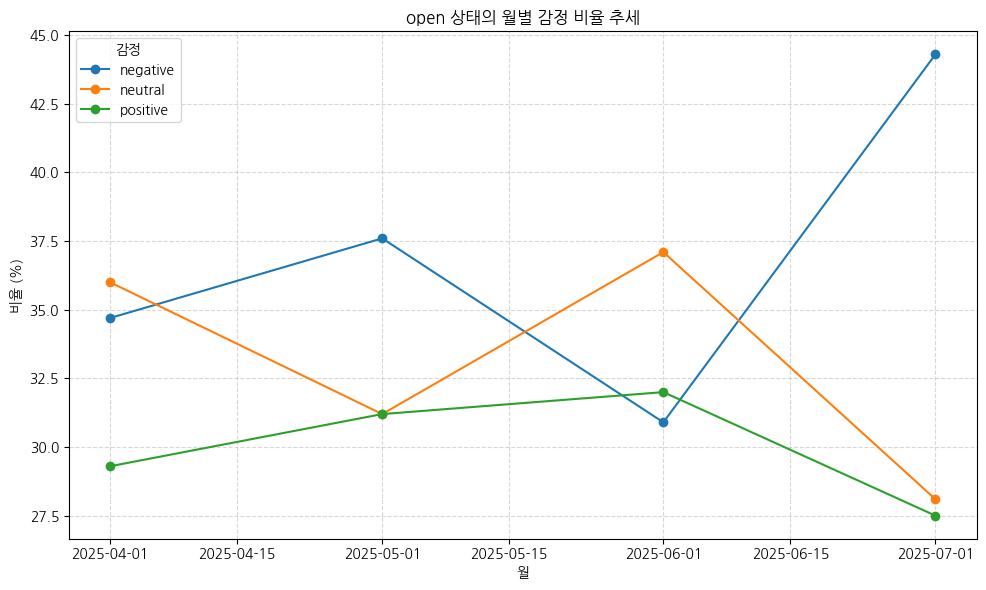

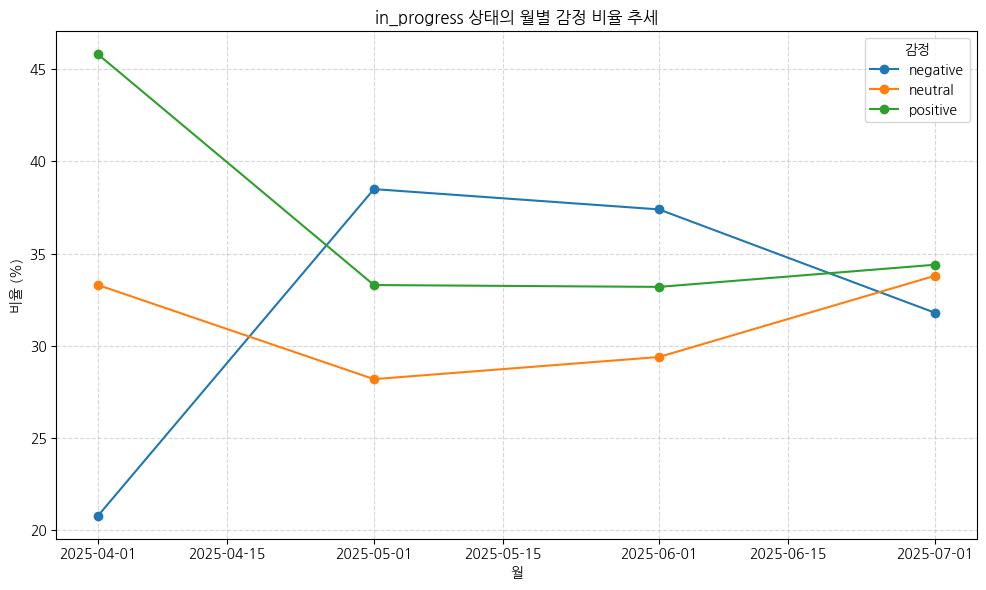

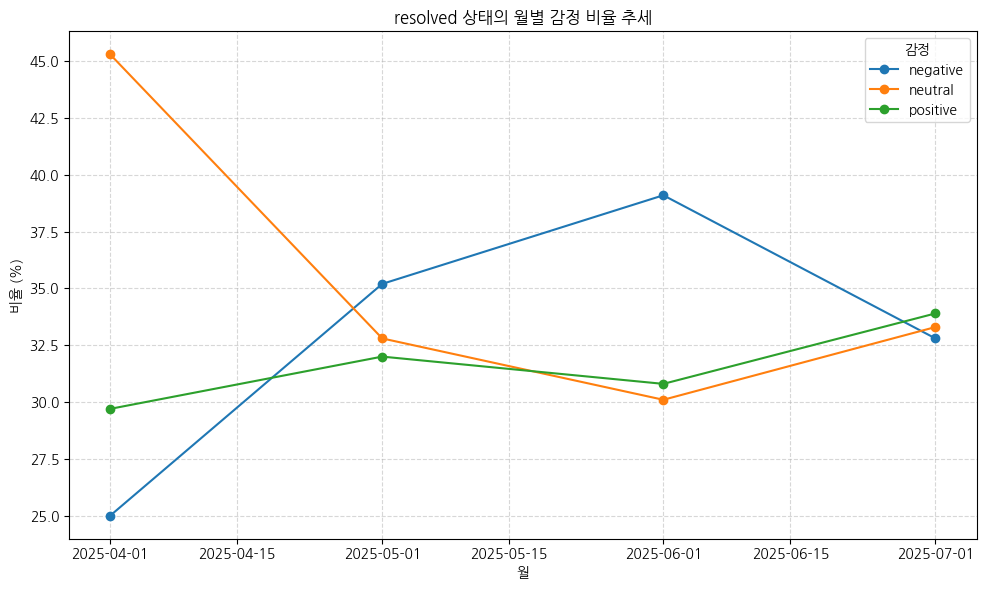

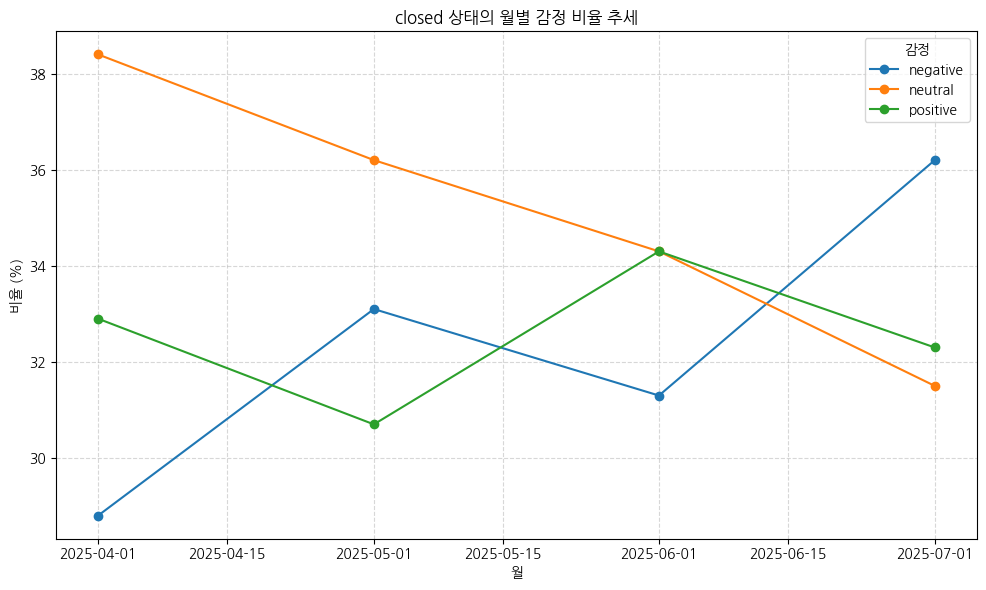

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 1) 전처리: 월 컬럼
chat_events['sent_at'] = pd.to_datetime(chat_events['sent_at'])
chat_events['month'] = chat_events['sent_at'].dt.to_period('M').dt.to_timestamp()

# 2) 월×상태×감정 집계 + 비율
monthly = (
    chat_events
    .groupby(['month','status','emotion'])
    .size()
    .reset_index(name='count')
)
monthly['ratio'] = (
    monthly['count'] /
    monthly.groupby(['month','status'])['count'].transform('sum') * 100
).round(1)

# 3) 상태별로 “그림 하나씩” (아까 보던 스타일)
status_order = ['open','in_progress','resolved','closed']
for st in [s for s in status_order if s in monthly['status'].unique()]:
    sub = monthly[monthly['status'] == st]
    pivot = sub.pivot(index='month', columns='emotion', values='ratio').fillna(0)

    plt.figure(figsize=(10,6))
    for col in pivot.columns:
        plt.plot(pivot.index, pivot[col], marker='o', label=col)

    plt.title(f"{st} 상태의 월별 감정 비율 추세")
    plt.xlabel("월")
    plt.ylabel("비율 (%)")
    plt.legend(title="감정")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


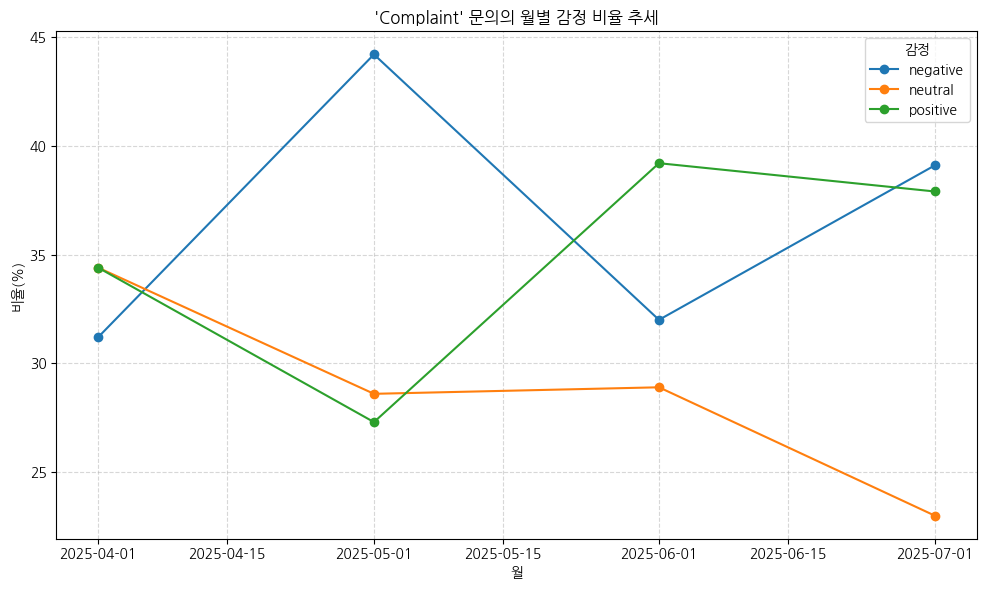

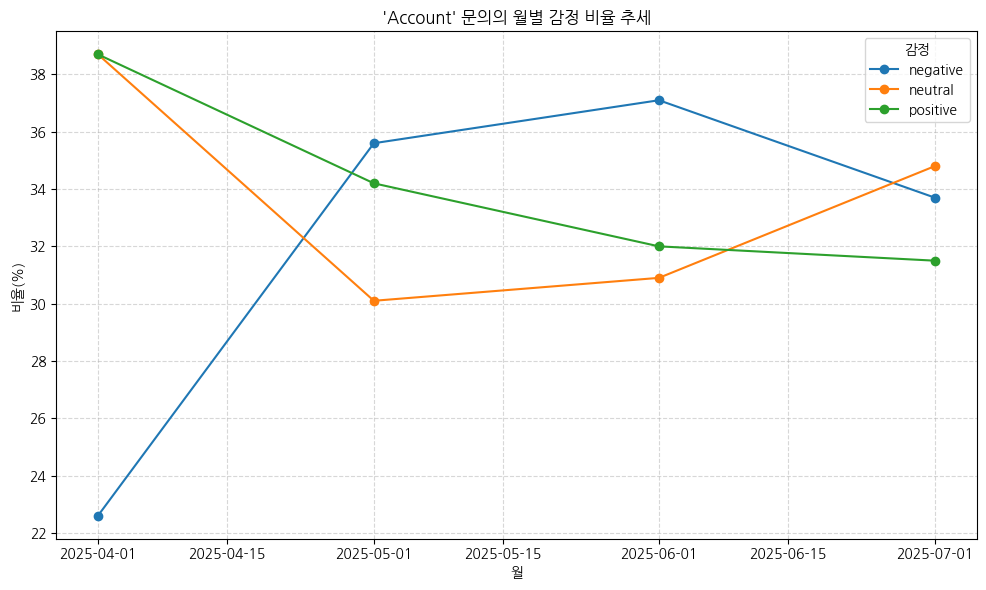

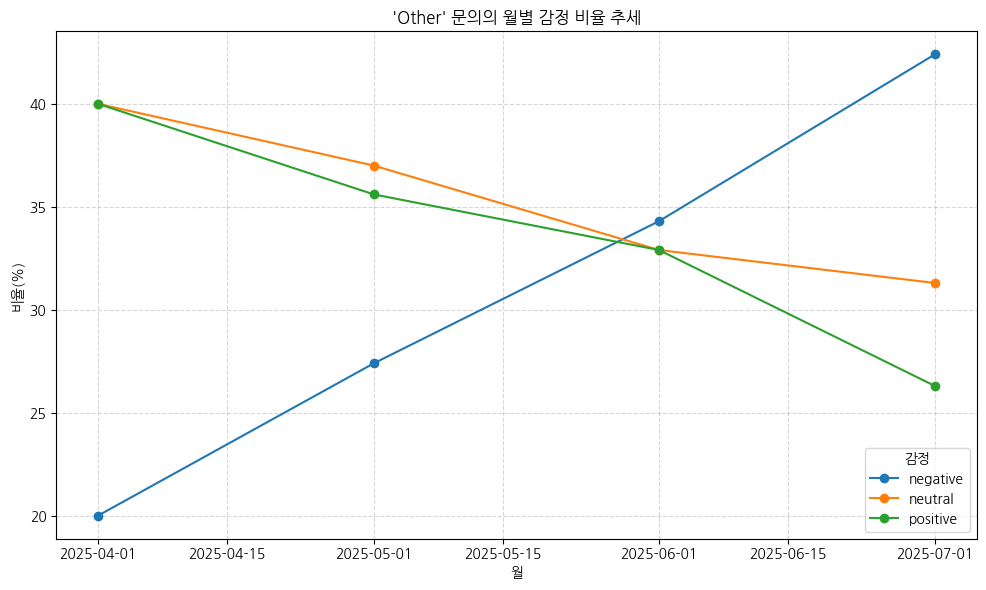

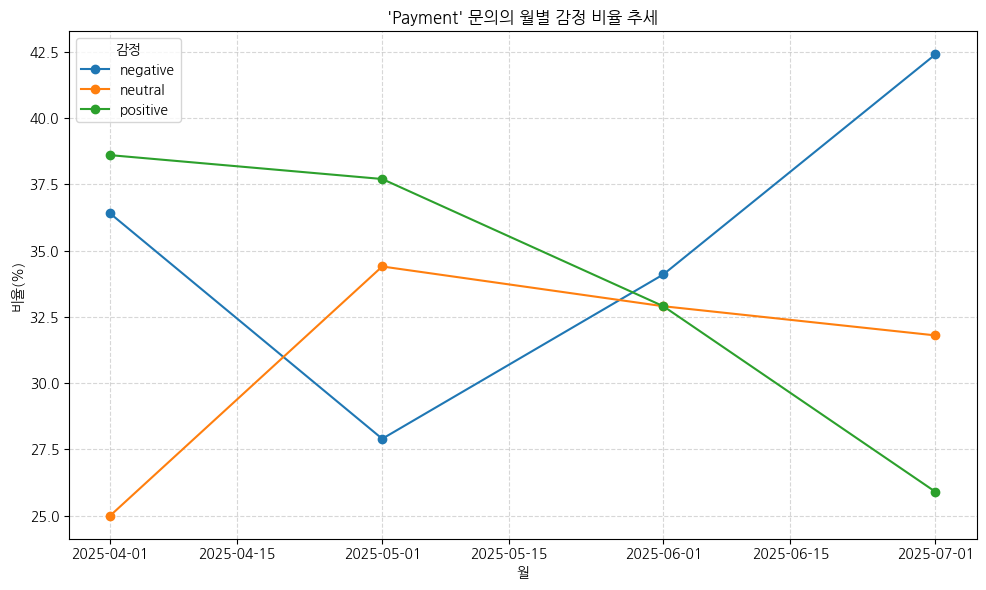

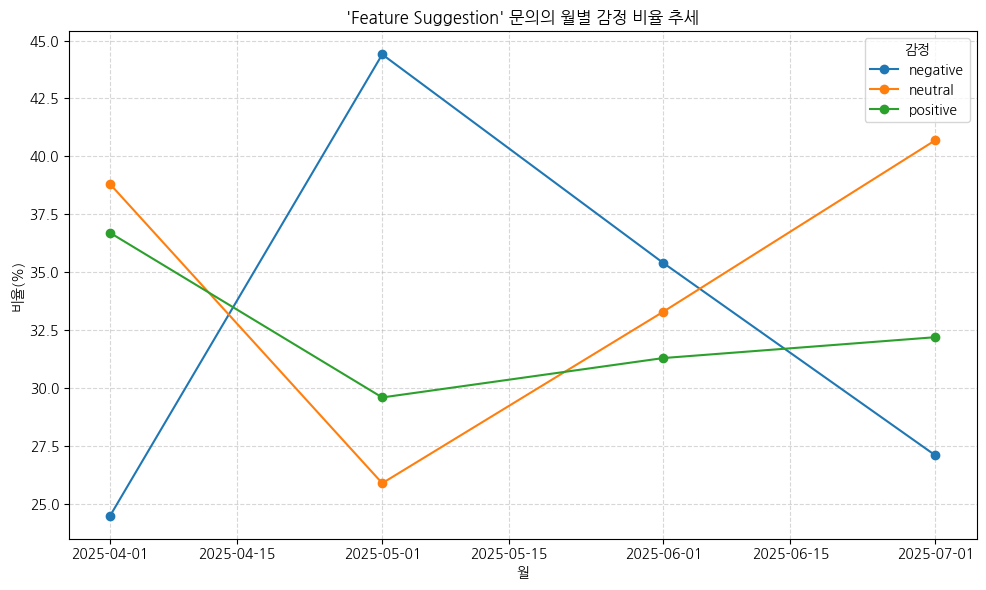

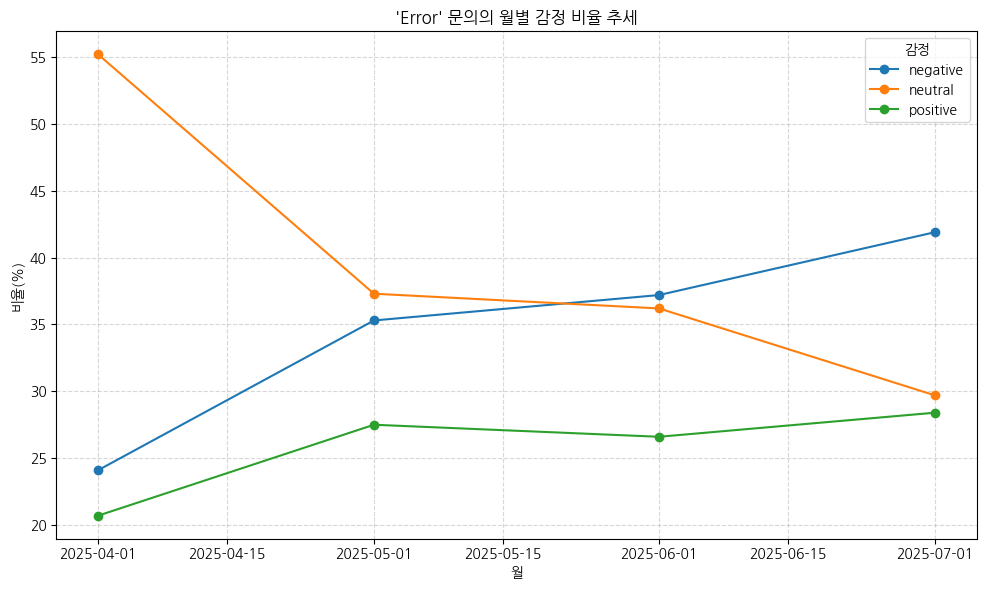

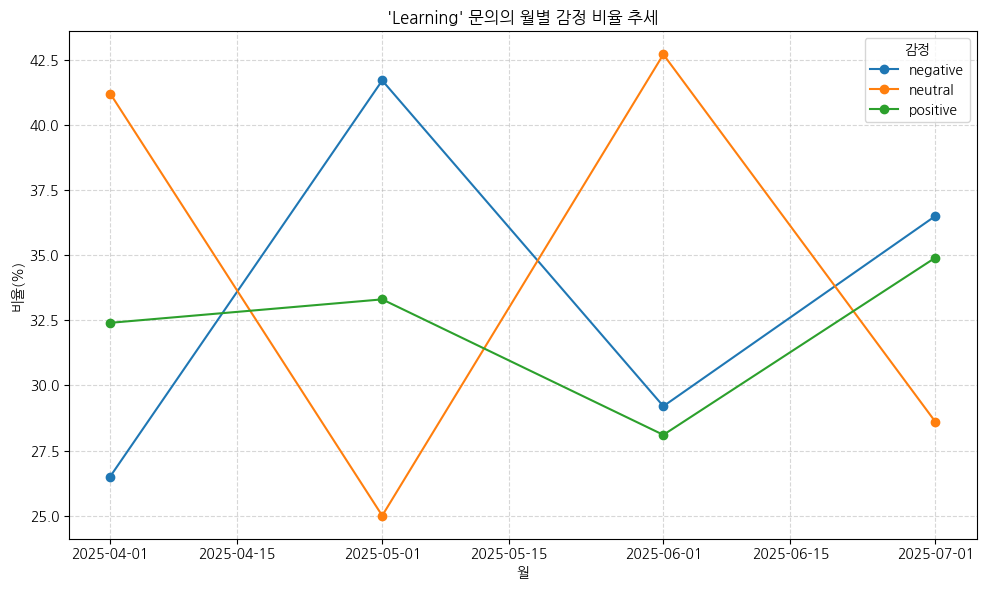

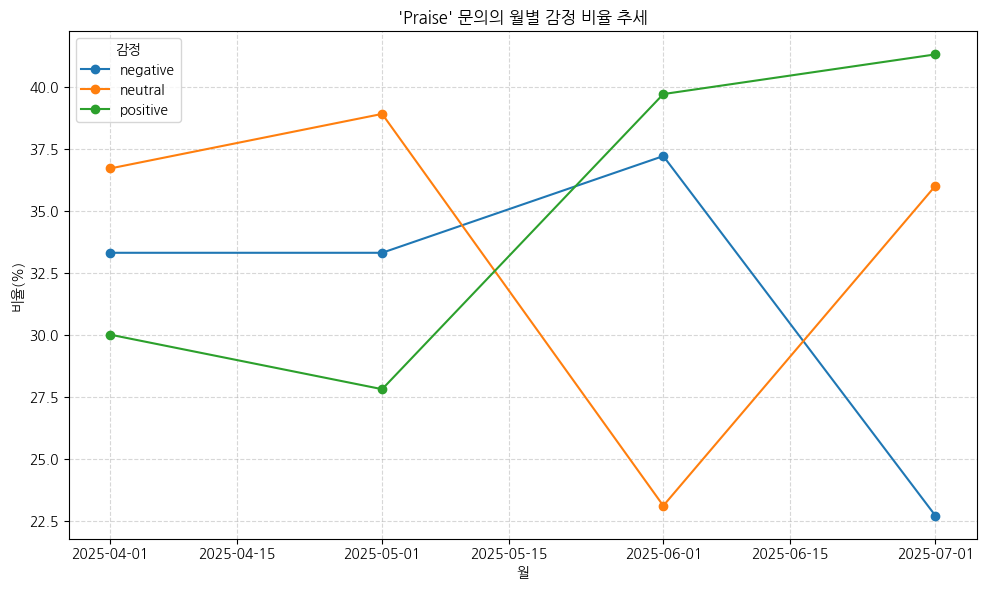

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib  # 한글 폰트

# 1) 날짜 전처리 + 월 컬럼
chat_events['sent_at'] = pd.to_datetime(chat_events['sent_at'])
chat_events['month'] = chat_events['sent_at'].dt.to_period('M').dt.to_timestamp()


# 3) 상위 N개 태그 선택 (너무 많으면 차트가 과다 생성되므로 제한)
TOP_N = 8
top_tags = chat_events['tag'].value_counts().head(TOP_N).index

# 4) 월 × 태그 × 감정 집계 및 '태그 내 월별 비율(%)' 계산
monthly_tag_emotion = (
    chat_events
    .groupby(['month', 'tag', 'emotion'])
    .size()
    .reset_index(name='count')
)

# 태그별(동일 월) 총합으로 나눠 비율 계산
monthly_tag_emotion['ratio'] = (
    monthly_tag_emotion['count'] /
    monthly_tag_emotion.groupby(['month', 'tag'])['count'].transform('sum') * 100
).round(1)

# 5) 태그별로 “아까 스타일”의 선 그래프 생성
for tg in top_tags:
    sub = monthly_tag_emotion[monthly_tag_emotion['tag'] == tg]
    pivot = sub.pivot(index='month', columns='emotion', values='ratio').fillna(0)

    plt.figure(figsize=(10,6))
    for col in pivot.columns:
        plt.plot(pivot.index, pivot[col], marker='o', label=col)

    plt.title(f"'{tg}' 문의의 월별 감정 비율 추세")
    plt.xlabel("월")
    plt.ylabel("비율(%)")
    plt.legend(title="감정")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


### 월별 처리 상태별 부정건수

In [ ]:
import pandas as pd

# 1) 날짜 변환
chat_events['sent_at'] = pd.to_datetime(chat_events['sent_at'])
chat_events['month'] = chat_events['sent_at'].dt.to_period('M').dt.to_timestamp()

# 2) 6~7월 데이터 필터링
recent_df = chat_events[
    (chat_events['month'] >= '2025-06-01') &
    (chat_events['month'] <= '2025-07-31')
]

# 3) 부정 감정만 필터링
negative_df = recent_df[recent_df['emotion'] == 'negative']

# 4) 처리 상태별 부정 건수
status_counts = (
    negative_df.groupby('status')
    .size()
    .reset_index(name='negative_count')
    .sort_values('negative_count', ascending=False)
)

# 5) 문의 유형별 부정 건수
tag_counts = (
    negative_df.groupby('tag')
    .size()
    .reset_index(name='negative_count')
    .sort_values('negative_count', ascending=False)
)

# 6) 결과 출력
print("📌 6~7월 처리 상태별 부정 건수")
print(status_counts)
print("\n📌 6~7월 문의 유형별 부정 건수")
print(tag_counts)


📌 6~7월 처리 상태별 부정 건수
        status  negative_count
2         open             128
3     resolved             121
1  in_progress             119
0       closed             109

📌 6~7월 문의 유형별 부정 건수
                  tag  negative_count
0             Account              67
2               Error              66
5               Other              66
1           Complaint              65
6             Payment              65
3  Feature Suggestion              51
4            Learning              51
7              Praise              46


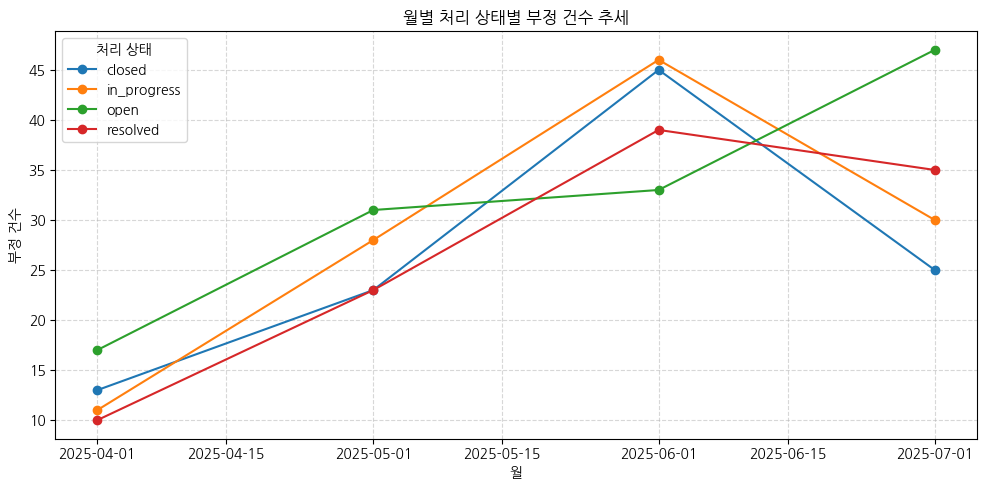

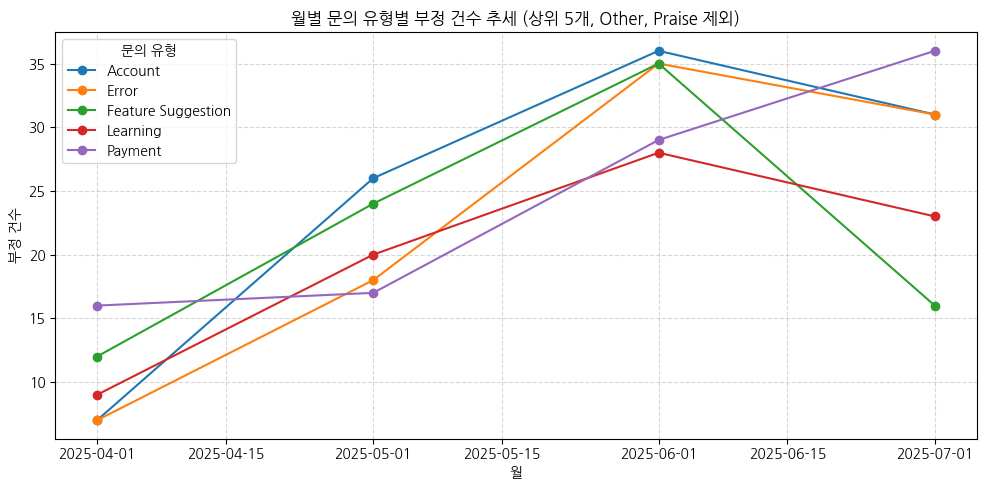

In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 1) 날짜 변환 + 월 컬럼
chat_events['sent_at'] = pd.to_datetime(chat_events['sent_at'])
chat_events['month'] = chat_events['sent_at'].dt.to_period('M').dt.to_timestamp()

# 2) 부정 감정 필터 + 'Other', 'Praise' 제외
negative_df = chat_events[
    (chat_events['emotion'] == 'negative') &
    (~chat_events['tag'].isin(['Other', 'Praise','Complaint']))
]

# 3) 월별 처리 상태별 부정 건수
status_monthly = (
    negative_df.groupby(['month', 'status'])
    .size()
    .reset_index(name='negative_count')
    .pivot(index='month', columns='status', values='negative_count')
    .fillna(0)
)

# 4) 월별 문의 유형별 부정 건수 (상위 5개만)
top_tags = (
    negative_df['tag']
    .value_counts()
    .head(5)
    .index
)

tag_monthly = (
    negative_df[negative_df['tag'].isin(top_tags)]
    .groupby(['month', 'tag'])
    .size()
    .reset_index(name='negative_count')
    .pivot(index='month', columns='tag', values='negative_count')
    .fillna(0)
)

# 5) 시각화 - 처리 상태별
plt.figure(figsize=(10,5))
for col in status_monthly.columns:
    plt.plot(status_monthly.index, status_monthly[col], marker='o', label=col)
plt.title('월별 처리 상태별 부정 건수 추세')
plt.xlabel('월')
plt.ylabel('부정 건수')
plt.legend(title='처리 상태')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 6) 시각화 - 문의 유형별 (상위 5개)
plt.figure(figsize=(10,5))
for col in tag_monthly.columns:
    plt.plot(tag_monthly.index, tag_monthly[col], marker='o', label=col)
plt.title('월별 문의 유형별 부정 건수 추세 (상위 5개, Other, Praise 제외)')
plt.xlabel('월')
plt.ylabel('부정 건수')
plt.legend(title='문의 유형')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



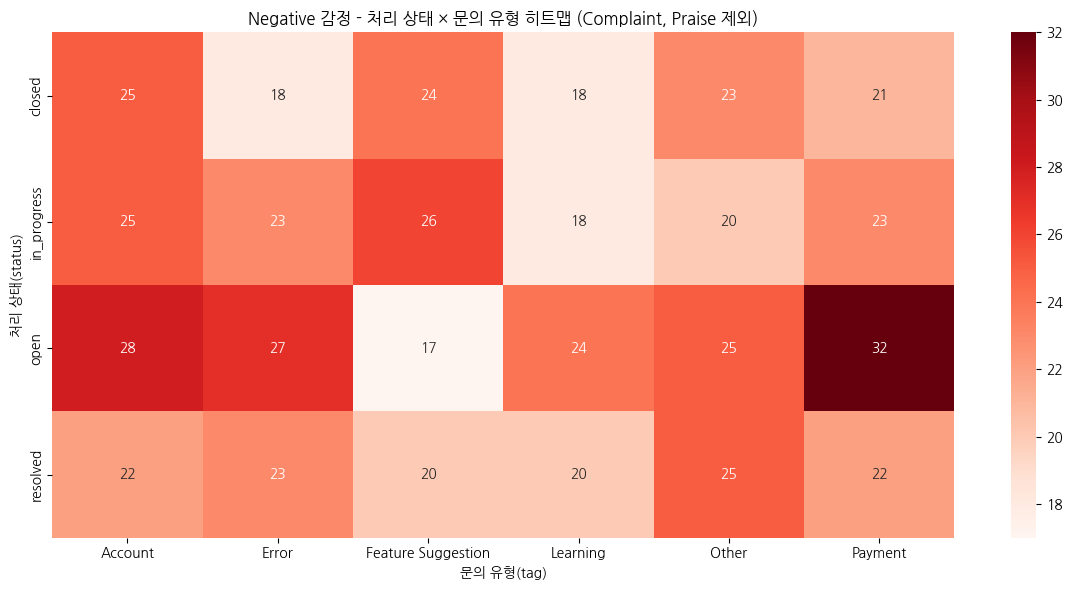

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 1) 부정 감정 데이터 필터 + 특정 태그 제외
negative_df = chat_events[
    (chat_events['emotion'] == 'negative') &
    (~chat_events['tag'].isin(['Complaint', 'Praise']))
].copy()

# 2) tag × status 부정 건수 피벗
neg_pivot = (
    negative_df.groupby(['status', 'tag'])
    .size()
    .reset_index(name='negative_count')
    .pivot(index='status', columns='tag', values='negative_count')
    .fillna(0)
)

# 3) 히트맵 시각화
plt.figure(figsize=(12,6))
sns.heatmap(neg_pivot, annot=True, fmt=".0f", cmap="Reds")
plt.title("Negative 감정 - 처리 상태 × 문의 유형 히트맵 (Complaint, Praise 제외)")
plt.xlabel("문의 유형(tag)")
plt.ylabel("처리 상태(status)")
plt.tight_layout()
plt.show()


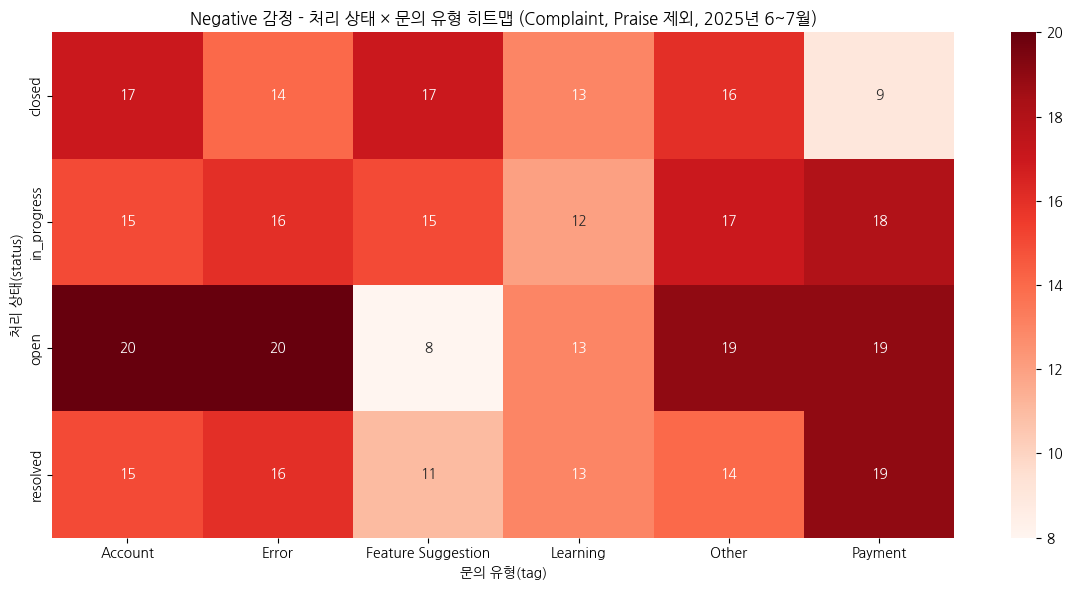

In [ ]:
#날짜 필터링되는 히트맵
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 1) 날짜 변환
chat_events['sent_at'] = pd.to_datetime(chat_events['sent_at'])
chat_events['month'] = chat_events['sent_at'].dt.to_period('M').dt.to_timestamp()

# 2) 부정 감정 데이터 필터 + 특정 태그 제외 + 6~7월 필터링
negative_df = chat_events[
    (chat_events['emotion'] == 'negative') &
    (~chat_events['tag'].isin(['Complaint', 'Praise'])) &
    (chat_events['month'] >= '2025-06-01') &
    (chat_events['month'] <= '2025-07-31')
].copy()

# 3) tag × status 부정 건수 피벗
neg_pivot = (
    negative_df.groupby(['status', 'tag'])
    .size()
    .reset_index(name='negative_count')
    .pivot(index='status', columns='tag', values='negative_count')
    .fillna(0)
)

# 4) 히트맵 시각화
plt.figure(figsize=(12,6))
sns.heatmap(neg_pivot, annot=True, fmt=".0f", cmap="Reds")
plt.title("Negative 감정 - 처리 상태 × 문의 유형 히트맵 (Complaint, Praise 제외, 2025년 6~7월)")
plt.xlabel("문의 유형(tag)")
plt.ylabel("처리 상태(status)")
plt.tight_layout()
plt.show()


## 인사이트
목적  
* 더 나은 서비스 제공과 고객 만족도 개선을 위한 데이터 분석

방법 1: 문의 유형별 처리 상태 x 감정 분석  
* 결과: 문의 유형별·감정별 비율이 전반적으로 균등하게 분포
* 해석: 특정 유형·감정에서 두드러진 편차가 없어, 현재 데이터로는 개선 포인트 식별 어려움

  
방법 2: 기간별(월별) 감정 비율 분석
* 결과: 부정 감정(negative) 비율이 점진적으로 증가하는 추세 확인
* 가정: 신규 고객이 늘어나면서 부정 감정을 가진 사람의 절대 건수도 증가했을 것
* 증명:
  * 월별 신규 가입자 수와 negative 건수를 비교한 결과, 두 지표가 유사한 증가 패턴을 보임
  * Complaint 건수 역시 같은 흐름 → 신규 고객 증가에 따른 자연스러운 부정/불만 건수 증가로 해석 가능  
* 보완 필요: 비율 증가의 원인은 추가 분석 필요  


방법 3 : 월별 처리 상태별 부정 건수 비교
* Complaint와 Praise를 제외하고 (필요 없는 항목) Nevative 감정에 대한 처리상태(status)와 문의 유형(tag)의 건수를 히트맵으로 작성
* 결과 : 문의 유형=Payment, 처리 상태 = open가 가장 많이 부정적이라는 점 식별
* 해석 : 비율 증가의 원인은 문의 유형=Payment, 처리 상태 = open의 증가 때문




# abtest
가설 : 가격을 낮추면 전환율이 올라갈 것이다

In [ ]:
# === pricing_ab: trial_to_paid / signup 전환율 계산 ===
import pandas as pd

# ----- 설정 -----
OBS_WINDOW_DAYS = None   # 예: 30 으로 설정하면 가입 후 30일 내 전환만 인정
USE_ACTIVE_GUARD = False # True로 하면 plan_status=='active'인 경우만 전환으로 인정

# 1) 실험 코호트 (A/B)
ab = ab_assignment.query("experiment_name == 'pricing_ab'").copy()
keep_cols = ['user_id', 'variant'] + (['assigned_at'] if 'assigned_at' in ab.columns else [])
ab = ab[keep_cols]
if 'assigned_at' in ab.columns:
    ab['assigned_at'] = pd.to_datetime(ab['assigned_at'], errors='coerce')
    ab = ab.sort_values('assigned_at').drop_duplicates('user_id', keep='first')
else:
    ab = ab.drop_duplicates('user_id')

# 2) 가입 시점 (signup_completed)
elog = event_logs.loc[event_logs['event_name'] == 'signup_completed', ['user_id','event_timestamp']].copy()
elog['event_timestamp'] = pd.to_datetime(elog['event_timestamp'], errors='coerce')
signup = (elog.sort_values('event_timestamp')
              .drop_duplicates('user_id', keep='first')
              .rename(columns={'event_timestamp':'signup_time'}))

# 실험 × 가입 조인 (가입이 있는 유저만 대상)
ab_signup = ab.merge(signup, on='user_id', how='inner')
if 'assigned_at' in ab_signup.columns:
    ab_signup = ab_signup.loc[
        ab_signup['assigned_at'].isna() | (ab_signup['signup_time'] >= ab_signup['assigned_at'])
    ].copy()

# 3) 전환 이벤트: trial_to_paid (최초 1건)
ph = plan_history.loc[plan_history['reason'] == 'trial_to_paid', ['user_id','plan_status','change_time']].copy()
ph['change_time'] = pd.to_datetime(ph['change_time'], errors='coerce')
if USE_ACTIVE_GUARD:
    ph = ph.loc[ph['plan_status'] == 'active']
conv = (ph.sort_values('change_time')
          .drop_duplicates('user_id', keep='first')
          .rename(columns={'change_time':'conv_time'}))

# 4) 가입 이후 전환만 인정 (+관찰 창 옵션)
df = ab_signup.merge(conv[['user_id','conv_time']], on='user_id', how='left')
df['converted'] = df['conv_time'].ge(df['signup_time'])
df.loc[df['conv_time'].isna(), 'converted'] = False
if OBS_WINDOW_DAYS:
    window_end = df['signup_time'] + pd.to_timedelta(OBS_WINDOW_DAYS, unit='D')
    df['converted'] = df['converted'] & (df['conv_time'] <= window_end)

# 5) 전환율 집계 (trial_to_paid / signup)
summary = (df.groupby('variant')
             .agg(N_signup=('user_id','nunique'),
                  N_trial_to_paid=('converted','sum'))
             .reset_index())
summary['CR_trial_to_paid'] = summary['N_trial_to_paid'] / summary['N_signup']

# 보기 좋게 A/B 정렬
if set(['A','B']).issubset(summary['variant'].unique()):
    summary = summary.set_index('variant').loc[['A','B']].reset_index()

print(summary)


  variant  N_signup  N_trial_to_paid  CR_trial_to_paid
0       A       429              157          0.365967
1       B       450              160          0.355556


In [ ]:
#가설2 : onboarding_cta를 바꾸면 전환율이 올라갈 것이다
#가설3 : checkout_design를 바꾸면 전환율이 올라갈 것이다

import pandas as pd
import numpy as np

# ===== 공통 유틸 =====
def _to_dt(s):
    return pd.to_datetime(s, errors='coerce')

def compute_cr_trial_to_paid_signup(ab_assignment, event_logs, plan_history, experiment_name,
                                    obs_window_days=None, use_active_guard=False):
    # 실험 코호트
    cols = ['user_id','variant'] + (['assigned_at'] if 'assigned_at' in ab_assignment.columns else [])
    ab = (ab_assignment.query("experiment_name == @experiment_name")[cols]
          .drop_duplicates('user_id'))
    if 'assigned_at' in ab.columns:
        ab['assigned_at'] = _to_dt(ab['assigned_at'])

    # 가입 시점
    sign = (event_logs.loc[event_logs['event_name'] == 'signup_completed', ['user_id','event_timestamp']]
                     .rename(columns={'event_timestamp':'signup_time'}))
    sign['signup_time'] = _to_dt(sign['signup_time'])
    sign = sign.sort_values('signup_time').drop_duplicates('user_id', keep='first')

    ab_sign = ab.merge(sign, on='user_id', how='inner')
    if 'assigned_at' in ab_sign.columns:
        ab_sign = ab_sign[(ab_sign['assigned_at'].isna()) | (ab_sign['signup_time'] >= ab_sign['assigned_at'])].copy()

    # 전환 이벤트: trial_to_paid (최초 1건)
    ph = plan_history.loc[plan_history['reason'] == 'trial_to_paid', ['user_id','plan_status','change_time']].copy()
    ph['change_time'] = _to_dt(ph['change_time'])
    if use_active_guard:
        ph = ph[ph['plan_status'] == 'active']
    conv = ph.sort_values('change_time').drop_duplicates('user_id', keep='first').rename(columns={'change_time':'conv_time'})

    # 가입 이후 전환만 인정 (+옵션: 관찰윈도우)
    df = ab_sign.merge(conv[['user_id','conv_time']], on='user_id', how='left')
    df['converted'] = df['conv_time'].ge(df['signup_time'])
    df.loc[df['conv_time'].isna(), 'converted'] = False
    if obs_window_days:
        win_end = df['signup_time'] + pd.to_timedelta(obs_window_days, unit='D')
        df['converted'] = df['converted'] & (df['conv_time'] <= win_end)

    summary = (df.groupby('variant')
                 .agg(N_signup=('user_id','nunique'),
                      N_trial_to_paid=('converted','sum'))
                 .reset_index())
    summary['CR_trial_to_paid'] = summary['N_trial_to_paid'] / summary['N_signup']

    # A/B 정렬(있을 경우)
    if set(['A','B']).issubset(summary['variant'].unique()):
        summary = summary.set_index('variant').loc[['A','B']].reset_index()

    return summary

def ztest_from_summary(summary, variant_order=('A','B')):
    t = summary.set_index('variant')
    # 안전 처리: 없는 variant가 있으면 자동으로 사전순 상위 2개 선택
    for v in variant_order:
        if v not in t.index:
            variant_order = tuple(t.index[:2])
            break
    c = t.loc[list(variant_order), 'N_trial_to_paid'].astype(int).values
    n = t.loc[list(variant_order), 'N_signup'].astype(int).values
    # statsmodels 있으면 사용, 없으면 수식
    try:
        from statsmodels.stats.proportion import proportions_ztest
        stat, p = proportions_ztest(c, n, alternative='two-sided')
    except Exception:
        p_pool = (c.sum()) / (n.sum())
        se = np.sqrt(p_pool*(1-p_pool)*(1/n[0] + 1/n[1]))
        stat = ((c[1]/n[1]) - (c[0]/n[0])) / se if se > 0 else np.nan
        from math import erf, sqrt
        cdf = lambda x: 0.5*(1 + erf(x/np.sqrt(2)))
        p = 2 * (1 - cdf(abs(stat))) if np.isfinite(stat) else np.nan

    return {
        'order': variant_order,
        'A_users': n[0], 'A_conv': c[0], 'A_cr': c[0]/n[0] if n[0] else np.nan,
        'B_users': n[1], 'B_conv': c[1], 'B_cr': c[1]/n[1] if n[1] else np.nan,
        'z': stat, 'p': p,
        'abs_lift': (c[1]/n[1]) - (c[0]/n[0]),
        'rel_lift': ((c[1]/n[1]) / (c[0]/n[0]) - 1) if c[0] > 0 else np.nan
    }

# ===== 실행: 두 실험 각각 전환율 계산 + 검정 =====
for exp in ['onboarding_cta', 'checkout_design']:
    print(f"\n==== {exp} :: trial_to_paid / signup ====")
    summ = compute_cr_trial_to_paid_signup(ab_assignment, event_logs, plan_history,
                                           experiment_name=exp,
                                           obs_window_days=None,      # 필요시 30 등으로 설정
                                           use_active_guard=False)    # 표본 작은 경우 False 권장
    print(summ)

    test = ztest_from_summary(summ, variant_order=('A','B'))
    print(f"Z = {test['z']:.4f}, p = {test['p']:.6f}")
    print(f"{test['order'][0]}: {test['A_conv']}/{test['A_users']} (CR={test['A_cr']:.4%})  |  "
          f"{test['order'][1]}: {test['B_conv']}/{test['B_users']} (CR={test['B_cr']:.4%})")
    print(f"Lift (B - A): abs={test['abs_lift']:.4%}, rel={test['rel_lift']:.2%}")



==== onboarding_cta :: trial_to_paid / signup ====
    variant  N_signup  N_trial_to_paid  CR_trial_to_paid
0  original       200               65          0.325000
1      test       207               70          0.338164
Z = -0.2820, p = 0.777947
original: 65/200 (CR=32.5000%)  |  test: 70/207 (CR=33.8164%)
Lift (B - A): abs=1.3164%, rel=4.05%

==== checkout_design :: trial_to_paid / signup ====
    variant  N_signup  N_trial_to_paid  CR_trial_to_paid
0   control        60                5          0.083333
1  redesign        71                6          0.084507
Z = -0.0241, p = 0.980746
control: 5/60 (CR=8.3333%)  |  redesign: 6/71 (CR=8.4507%)
Lift (B - A): abs=0.1174%, rel=1.41%


## 인사이트
전환율의 상승을 목적으로 하는 3가지의 abtest는
전환율이 pricing_ab , onboarding_cta , checkout_design에 영향을 받는다고 할 충분한 증거가 없기 때문에 기각

# 코호트 분석
문제점 :유료 전환 후 유지는 잘 되지만, 체험(trial) 후 유료 전환을 하지 않은 고객 비율이 높다.   
목표 : 코호트 분석을 통해 > 월별/ 주간별 전환율을 확인해보고 이상점이 있는지 발견해보자  
전환율의 정의 : plan_history[reason] > trial_to_paid / sign_up 의 비율로 계산

In [ ]:
import pandas as pd
import numpy as np
import re

# -----------------------
# 파라미터
# -----------------------
TRIAL_DAYS = 7
GRACE_DAYS = 3
MAX_LAG_DAYS = 60   # signup 후 trial 시작을 기다려 줄 최대 기간(지표 안정용)
WEEK_START = 'MON'

# -----------------------
# 유틸: 타임스탬프 컬럼 자동 탐색 + 파싱
# -----------------------
def choose_ts_col(df):
    # 후보 1: 흔한 이름들 우선
    pri = ['event_timestamp','timestamp','changed_at','created_at','plan_start_date','event_time','occurred_at']
    for c in pri:
        if c in df.columns:
            col = c
            s = pd.to_datetime(df[col], errors='coerce')
            if s.notna().sum() > 0:
                df[col] = s
                return col

    # 후보 2: 이름 패턴으로 스캔
    cand = [c for c in df.columns if re.search(r'(time|date|stamp|_at|_ts)$', str(c), flags=re.I)]
    best_col, best_nonnull = None, -1
    for c in cand:
        s = pd.to_datetime(df[c], errors='coerce')
        nn = s.notna().sum()
        if nn > best_nonnull:
            best_col, best_nonnull = c, nn
            df[c] = s
    return best_col

# -----------------------
# 0) 정규화
# -----------------------
ph = plan_history.copy()

# reason / plan_status 정규화
for col in ['reason','plan_status']:
    if col in ph.columns:
        ph[col] = ph[col].astype(str).str.strip().str.lower()

ts_col = choose_ts_col(ph)  # plan_history에서 쓸 타임스탬프
if ts_col is None:
    # 최후의 수단: users.created_at 사용
    if 'created_at' not in users.columns:
        raise ValueError("날짜 컬럼을 찾지 못했습니다. plan_history 또는 users에 날짜/시간 컬럼이 필요합니다.")
    users = users.copy()
    users['created_at'] = pd.to_datetime(users['created_at'], errors='coerce')

# -----------------------
# 1) signup_ts
# -----------------------
if 'reason' in ph.columns and ts_col and (ph['reason'] == 'signup').any():
    signup = (ph.loc[ph['reason'].eq('signup'), ['user_id', ts_col]]
                .dropna()
                .sort_values([ts_col])
                .groupby('user_id', as_index=False).first()
                .rename(columns={ts_col:'signup_ts'}))
else:
    signup = (users[['user_id','created_at']]
                .dropna()
                .rename(columns={'created_at':'signup_ts'}))

# -----------------------
# 2) trial_start_ts (있으면 이걸 윈도우 기준으로)
#    - plan_status == 'trialing' 우선 사용
# -----------------------
trial_start = None
if 'plan_status' in ph.columns and ts_col:
    trial_start = (ph.loc[ph['plan_status'].eq('trialing'), ['user_id', ts_col]]
                     .dropna()
                     .sort_values([ts_col])
                     .groupby('user_id', as_index=False).first()
                     .rename(columns={ts_col:'trial_start_ts'}))

# -----------------------
# 3) outcome ts
# -----------------------
def first_event(df, reason_value, tscol):
    if ('reason' in df.columns) and tscol:
        tmp = (df.loc[df['reason'].eq(reason_value), ['user_id', tscol]]
                 .dropna()
                 .sort_values([tscol])
                 .groupby('user_id', as_index=False).first())
        return tmp.rename(columns={tscol: f'{reason_value}_ts'})
    else:
        # 타임스탬프가 없어도 존재 여부용 키는 만들자
        tmp = df.loc[df.get('reason','').eq(reason_value), ['user_id']].drop_duplicates()
        tmp[f'{reason_value}_ts'] = pd.NaT
        return tmp

paid = first_event(ph, 'trial_to_paid', ts_col)
expired = first_event(ph, 'trial_expired', ts_col)

# -----------------------
# 4) 병합 + 윈도우 설정
# -----------------------
base = signup.merge(paid, on='user_id', how='left') \
             .merge(expired, on='user_id', how='left')

if trial_start is not None:
    base = base.merge(trial_start, on='user_id', how='left')
else:
    base['trial_start_ts'] = pd.NaT

# 윈도우 시작: trial_start_ts가 있으면 그걸, 없으면 signup_ts
base['window_start'] = np.where(base['trial_start_ts'].notna(),
                                base['trial_start_ts'], base['signup_ts'])

# trial 미착수(non-starter) 식별(옵션): signup 후 MAX_LAG_DAYS 내 trial_start 없으면 non-starter
base['non_starter'] = base['trial_start_ts'].isna() & (
    (base['signup_ts'] + pd.to_timedelta(MAX_LAG_DAYS, 'D') < base['signup_ts'].max())
)

# 윈도우 종료: window_start + TRIAL_DAYS + GRACE_DAYS
window_days = TRIAL_DAYS + GRACE_DAYS
base['window_end'] = base['window_start'] + pd.to_timedelta(window_days, 'D')

# -----------------------
# 5) 윈도우 내 결과 판정(가장 이른 1건)
# -----------------------
def in_win(x, start, end):
    return x.between(start, end, inclusive='both')

if ts_col:
    base['paid_in_win'] = in_win(base['trial_to_paid_ts'], base['window_start'], base['window_end'])
    base['exp_in_win']  = in_win(base['trial_expired_ts'], base['window_start'], base['window_end'])

    paid_win = base['trial_to_paid_ts'].where(base['paid_in_win'])
    exp_win  = base['trial_expired_ts'].where(base['exp_in_win'])

    base['first_ts'] = pd.concat([paid_win, exp_win], axis=1).min(axis=1)

    base['outcome'] = np.where(base['first_ts'].isna(),
                               np.where(base['non_starter'], 'non_starter', 'pending'),
                               np.where(
                                   (paid_win.notna()) & ((exp_win.isna()) | (paid_win <= exp_win)),
                                   'paid', 'expired'
                               ))
    # 속도 지표
    base['ttp_days'] = np.where(base['outcome'].eq('paid'),
                                (paid_win - base['window_start']).dt.total_seconds()/86400, np.nan)
    base['tte_days'] = np.where(base['outcome'].eq('expired'),
                                (exp_win - base['window_start']).dt.total_seconds()/86400, np.nan)
else:
    # 타임스탬프 전혀 없으면: 존재 여부로만 라벨링(최선)
    has_paid = base['trial_to_paid_ts'].notna()
    has_exp  = base['trial_expired_ts'].notna() & ~has_paid
    base['outcome'] = np.where(has_paid, 'paid', np.where(has_exp, 'expired', 'pending'))
    base['ttp_days'] = np.nan
    base['tte_days'] = np.nan

# -----------------------
# 6) 코호트 키 + 집계
# -----------------------
base['cohort_month'] = base['signup_ts'].dt.to_period('M').dt.to_timestamp()
base['cohort_week']  = base['signup_ts'].dt.to_period('W-' + WEEK_START).apply(lambda r: r.start_time)

def make_cohort(df, key):
    agg = (df.groupby(key).agg(
        N_signup=('user_id','count'),
        N_paid=('outcome', lambda s: (s=='paid').sum()),
        N_expired=('outcome', lambda s: (s=='expired').sum()),
        N_pending=('outcome', lambda s: (s=='pending').sum()),
        N_nonstarter=('outcome', lambda s: (s=='non_starter').sum()),
        TTP_median_days=('ttp_days','median'),
        TTE_median_days=('tte_days','median'),
    ).reset_index())
    agg['paid_per_signup']      = agg['N_paid']/agg['N_signup']
    agg['expired_per_signup']   = agg['N_expired']/agg['N_signup']
    agg['pending_per_signup']   = agg['N_pending']/agg['N_signup']
    agg['nonstarter_per_signup']= agg['N_nonstarter']/agg['N_signup']
    agg['rate_sum'] = agg[['paid_per_signup','expired_per_signup','pending_per_signup','nonstarter_per_signup']].sum(axis=1)
    return agg.sort_values(key)

monthly_cohort = make_cohort(base, 'cohort_month')
weekly_cohort  = make_cohort(base, 'cohort_week')

print(monthly_cohort.head(12))
print(weekly_cohort.head(12))


  cohort_month  N_signup  N_paid  N_expired  N_pending  N_nonstarter  \
0   2025-04-01      2468     337        578       1553             0   
1   2025-05-01      4677     655       1173       2849             0   
2   2025-06-01      6585     890       1620       4075             0   
3   2025-07-01      5815     365        758       4692             0   

   TTP_median_days  TTE_median_days  paid_per_signup  expired_per_signup  \
0         8.377662         8.352465         0.136548            0.234198   
1         8.392106         8.360463         0.140047            0.250802   
2         8.376655         8.452315         0.135156            0.246014   
3         8.104294         8.168617         0.062769            0.130353   

   pending_per_signup  nonstarter_per_signup  rate_sum  
0            0.629254                    0.0       1.0  
1            0.609151                    0.0       1.0  
2            0.618831                    0.0       1.0  
3            0.806879         

In [ ]:
# 1) 실제 (trial_start → 결과) 소요 일수 분포 추정
d_paid = (base['trial_to_paid_ts'] - base['trial_start_ts']).dt.days
d_exp  = (base['trial_expired_ts'] - base['trial_start_ts']).dt.days
d = pd.concat([d_paid, d_exp]).dropna()

p50, p80, p90 = d.quantile([.5, .8, .9])
print({'p50': p50, 'p80': p80, 'p90': p90})

# 2) 새 윈도우 제안(예: P80 기준에 여유 +2일)
TRIAL_DAYS = int(np.ceil(p80))    # 예: 14일로 나올 가능성 큼
GRACE_DAYS = 2

# 3) window_end 재계산 + outcome 재라벨링 후 cohort 다시 집계
base['window_start'] = np.where(base['trial_start_ts'].notna(), base['trial_start_ts'], base['signup_ts'])
base['window_end']   = base['window_start'] + pd.to_timedelta(TRIAL_DAYS + GRACE_DAYS, 'D')

paid_win = base['trial_to_paid_ts'].where(base['trial_to_paid_ts'].between(base['window_start'], base['window_end']))
exp_win  = base['trial_expired_ts'].where(base['trial_expired_ts'].between(base['window_start'], base['window_end']))

first_ts = pd.concat([paid_win, exp_win], axis=1).min(axis=1)
base['outcome'] = np.where(first_ts.isna(), 'pending',
                           np.where(paid_win.notna() & ((exp_win.isna()) | (paid_win <= exp_win)),
                                    'paid','expired'))

def make_cohort(df, key):
    g = (df.groupby(key).agg(
        N_signup=('user_id','count'),
        N_paid=('outcome', lambda s: (s=='paid').sum()),
        N_expired=('outcome', lambda s: (s=='expired').sum()),
        N_pending=('outcome', lambda s: (s=='pending').sum()),
    ).reset_index())
    g['paid_per_signup']    = g['N_paid']/g['N_signup']
    g['expired_per_signup'] = g['N_expired']/g['N_signup']
    g['pending_per_signup'] = g['N_pending']/g['N_signup']
    return g.sort_values(key)

monthly_cohort = make_cohort(base, 'cohort_month')
weekly_cohort  = make_cohort(base, 'cohort_week')


{'p50': 10.0, 'p80': 16.0, 'p90': 20.0}


In [ ]:
import numpy as np
import pandas as pd

# 1) 새 관찰 윈도우 적용 (P80+여유)
TRIAL_DAYS = 16   # P80
GRACE_DAYS = 3
SNAPSHOT   = pd.Timestamp.today().normalize()

# window 기준: trial_start_ts가 있으면 그걸, 없으면 signup_ts
base['window_start'] = np.where(base['trial_start_ts'].notna(), base['trial_start_ts'], base['signup_ts'])
base['window_end']   = base['window_start'] + pd.to_timedelta(TRIAL_DAYS + GRACE_DAYS, 'D')

# 2) 윈도우 내 결과(가장 이른 1건)로 outcome 재라벨링
paid_win = base['trial_to_paid_ts'].where(base['trial_to_paid_ts'].between(base['window_start'], base['window_end'], inclusive='both'))
exp_win  = base['trial_expired_ts'].where(base['trial_expired_ts'].between(base['window_start'], base['window_end'], inclusive='both'))

first_ts = pd.concat([paid_win, exp_win], axis=1).min(axis=1)
base['outcome'] = np.where(first_ts.isna(), 'pending',
                           np.where(paid_win.notna() & ((exp_win.isna()) | (paid_win <= exp_win)),
                                    'paid', 'expired'))

# 속도 지표(옵션)
base['ttp_days'] = np.where(base['outcome'].eq('paid'),
                            (paid_win - base['window_start']).dt.total_seconds()/86400, np.nan)
base['tte_days'] = np.where(base['outcome'].eq('expired'),
                            (exp_win  - base['window_start']).dt.total_seconds()/86400, np.nan)

# 3) 코호트 키 (signup 기준은 유지)
base['cohort_month'] = base['signup_ts'].dt.to_period('M').dt.to_timestamp()
base['cohort_week']  = base['signup_ts'].dt.to_period('W-MON').apply(lambda r: r.start_time)

def make_cohort(df, key):
    g = (df.groupby(key).agg(
        N_signup=('user_id','count'),
        N_paid=('outcome',   lambda s: (s=='paid').sum()),
        N_expired=('outcome',lambda s: (s=='expired').sum()),
        N_pending=('outcome',lambda s: (s=='pending').sum()),
        TTP_median_days=('ttp_days','median'),
        TTE_median_days=('tte_days','median'),
    ).reset_index())
    g['paid_per_signup']    = g['N_paid']/g['N_signup']
    g['expired_per_signup'] = g['N_expired']/g['N_signup']
    g['pending_per_signup'] = g['N_pending']/g['N_signup']
    g['decision_coverage']  = 1 - g['pending_per_signup']  # 윈도우 내 ‘결과가 결정된’ 비율
    g['rate_sum'] = g[['paid_per_signup','expired_per_signup','pending_per_signup']].sum(axis=1)
    return g.sort_values(key)

# 4) 전체 vs 관찰 완료 코호트(스냅샷 이전에 window_end가 지난 것만)
monthly_all = make_cohort(base, 'cohort_month')
weekly_all  = make_cohort(base, 'cohort_week')

eligible = base.loc[base['window_end'] <= SNAPSHOT].copy()
monthly_final = make_cohort(eligible, 'cohort_month')
weekly_final  = make_cohort(eligible, 'cohort_week')

print("=== Monthly (ALL, 아직 진행중 포함) ===")
print(monthly_all.tail(6))
print("\n=== Monthly (ELIGIBLE ONLY, window 종료 코호트만) ===")
print(monthly_final.tail(6))

print("\n=== Weekly (ELIGIBLE ONLY) ===")
print(weekly_final.tail(10))


=== Monthly (ALL, 아직 진행중 포함) ===
  cohort_month  N_signup  N_paid  N_expired  N_pending  TTP_median_days  \
0   2025-04-01      2468     721       1331        416        10.388669   
1   2025-05-01      4677    1451       2585        641        10.449144   
2   2025-06-01      6585    1974       3604       1007        10.599716   
3   2025-07-01      5815     643       1339       3833         9.455926   

   TTE_median_days  paid_per_signup  expired_per_signup  pending_per_signup  \
0        10.707187         0.292139            0.539303            0.168558   
1        10.424873         0.310242            0.552705            0.137054   
2        10.479398         0.299772            0.547304            0.152923   
3         9.480729         0.110576            0.230267            0.659157   

   decision_coverage  rate_sum  
0           0.831442       1.0  
1           0.862946       1.0  
2           0.847077       1.0  
3           0.340843       1.0  

=== Monthly (ELIGIBLE ONLY, w

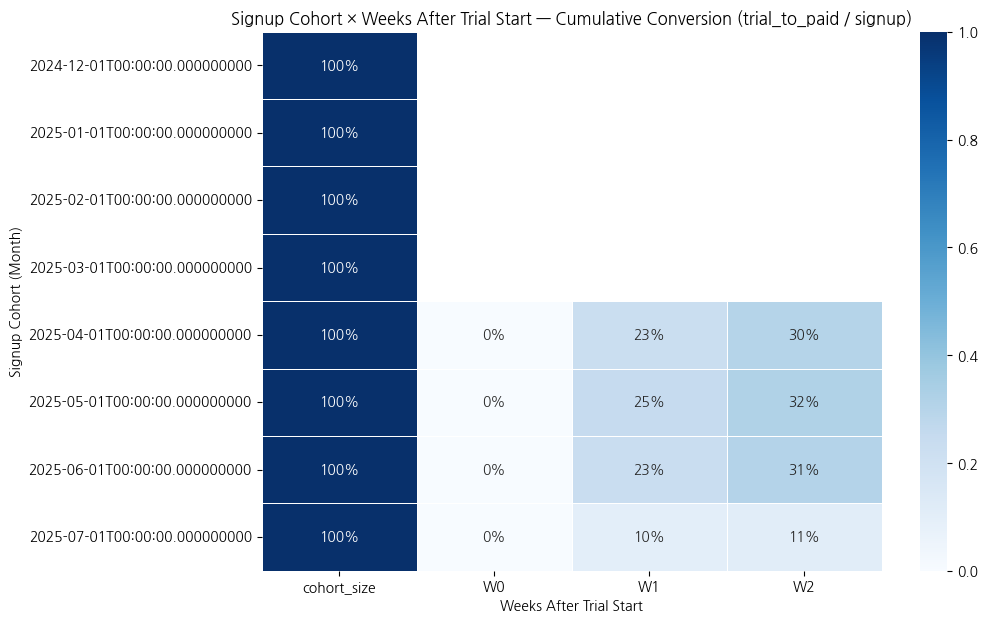

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 0) 정규화 & 타임스탬프 지정 ---
ph = plan_history.copy()
ph['reason'] = ph['reason'].astype(str).str.strip().str.lower()
ph['plan_status'] = ph['plan_status'].astype(str).str.strip().str.lower()

ts_col = 'change_time'
ph[ts_col] = pd.to_datetime(ph[ts_col], errors='coerce')

users = users.copy()
users['created_at'] = pd.to_datetime(users['created_at'], errors='coerce')

# --- 1) 핵심 타임포인트 ---
signup = users[['user_id','created_at']].rename(columns={'created_at':'signup_ts'}).dropna()

trial_start = (ph.loc[ph['plan_status'].eq('trialing'), ['user_id', ts_col]]
                 .dropna()
                 .sort_values(ts_col)
                 .groupby('user_id', as_index=False).first()
                 .rename(columns={ts_col:'trial_start_ts'}))

paid = (ph.loc[ph['reason'].eq('trial_to_paid'), ['user_id', ts_col]]
          .dropna()
          .sort_values(ts_col)
          .groupby('user_id', as_index=False).first()
          .rename(columns={ts_col:'paid_ts'}))

expired = (ph.loc[ph['reason'].eq('trial_expired'), ['user_id', ts_col]]
            .dropna()
            .sort_values(ts_col)
            .groupby('user_id', as_index=False).first()
            .rename(columns={ts_col:'expired_ts'}))

base = (signup
        .merge(trial_start, on='user_id', how='left')
        .merge(paid, on='user_id', how='left')
        .merge(expired, on='user_id', how='left'))

# --- 2) 관찰 윈도우 & 결과 라벨 ---
WINDOW_DAYS = 20  # P80(16) + 여유 3 ≈ 19 → 20일로
base['window_start'] = np.where(base['trial_start_ts'].notna(), base['trial_start_ts'], base['signup_ts'])
base['window_start'] = pd.to_datetime(base['window_start'])
base['window_end']   = base['window_start'] + pd.to_timedelta(WINDOW_DAYS, 'D')

paid_win = base['paid_ts'].where(base['paid_ts'].between(base['window_start'], base['window_end']))
exp_win  = base['expired_ts'].where(base['expired_ts'].between(base['window_start'], base['window_end']))
first_ts = pd.concat([paid_win, exp_win], axis=1).min(axis=1)

base['outcome'] = np.where(first_ts.isna(), 'pending',
                           np.where(paid_win.notna() & ((exp_win.isna()) | (paid_win <= exp_win)),
                                    'paid', 'expired'))

# --- 3) 경과 '주' 버킷(W0: D0-6, W1: D7-13, W2: D14-20) ---
is_paid_first = base['outcome'].eq('paid')
paid_age_days = (paid_win - base['window_start']).dt.days.where(is_paid_first)
paid_age_week = np.floor_divide(paid_age_days, 7).astype('float').clip(lower=0, upper=2)
base['paid_age_week'] = paid_age_week

# --- 4) 행 코호트(월별 signup) + 최신 코호트 검열 제거 ---
base['cohort_month'] = base['signup_ts'].dt.to_period('M').dt.to_timestamp()
SNAPSHOT = pd.Timestamp.today().normalize()
eligible = base.loc[base['window_end'] <= SNAPSHOT].copy()

# --- 5) 누적 전환율 계산: trial_to_paid / signup ---
denom = eligible.groupby('cohort_month')['user_id'].nunique().rename('N_signup')

paid_week_counts = (
    eligible.dropna(subset=['paid_age_week'])
            .assign(paid_age_week=lambda df: df['paid_age_week'].astype(int))
            .groupby(['cohort_month','paid_age_week'])['user_id'].nunique()
            .unstack(fill_value=0)  # columns: 0,1,2
)

for w in [0,1,2]:
    if w not in paid_week_counts.columns:
        paid_week_counts[w] = 0
paid_week_counts = paid_week_counts[[0,1,2]]

paid_cum = paid_week_counts.copy()
paid_cum[1] += paid_cum[0]
paid_cum[2] += paid_cum[1]

cr_cum = (paid_cum
          .div(denom, axis=0)
          .reindex(denom.index)
          .sort_index())

heat_df = pd.concat([pd.Series(1.0, index=cr_cum.index, name='cohort_size'),
                     cr_cum.rename(columns={0:'W0',1:'W1',2:'W2'})], axis=1)

# --- 6) 시각화 ---
plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    heat_df,
    annot=True, fmt='.0%',
    cmap='Blues', cbar=True,
    vmin=0.0, vmax=1.0,
    linewidths=.5, linecolor='white'
)
ax.set_title('Signup Cohort × Weeks After Trial Start — Cumulative Conversion (trial_to_paid / signup)')
ax.set_xlabel('Weeks After Trial Start'); ax.set_ylabel('Signup Cohort (Month)')
plt.yticks(rotation=0); plt.show()


In [ ]:
print(plan_history.columns)


Index(['user_id', 'change_time', 'plan_name', 'plan_status', 'reason'], dtype='object')


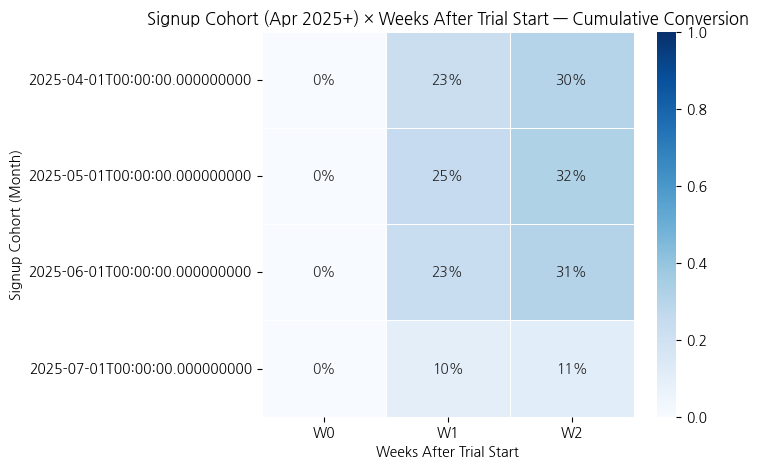

In [ ]:
# 4월(2025-04-01) 이후만 선택
heat_df_filtered = heat_df.loc[heat_df.index >= pd.Timestamp('2025-04-01'), ['W0','W1','W2']]

plt.figure(figsize=(6, 5))
ax = sns.heatmap(
    heat_df_filtered,
    annot=True, fmt='.0%',
    cmap='Blues', cbar=True,
    vmin=0.0, vmax=1.0,
    linewidths=.5, linecolor='white'
)
ax.set_title('Signup Cohort (Apr 2025+) × Weeks After Trial Start — Cumulative Conversion')
ax.set_xlabel('Weeks After Trial Start')
ax.set_ylabel('Signup Cohort (Month)')
plt.yticks(rotation=0)
plt.show()


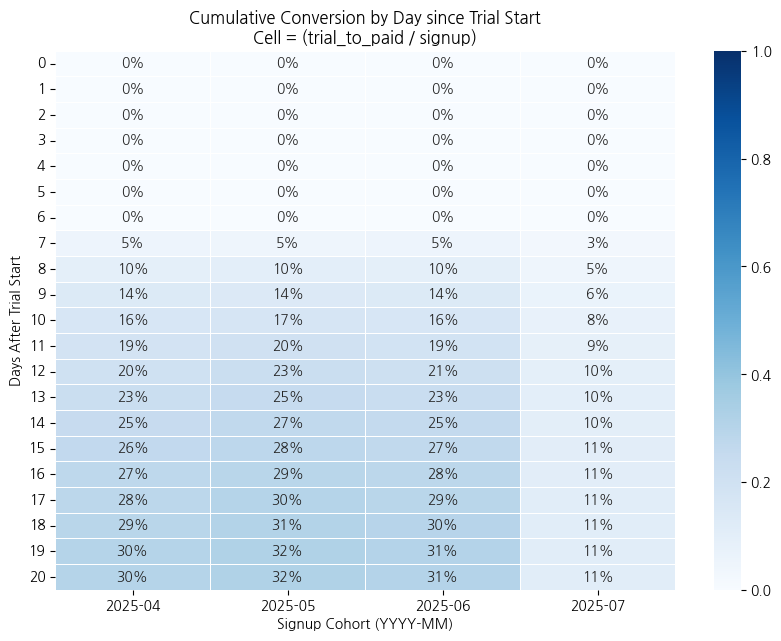

In [ ]:
# === Signup 코호트(열=YYYY-MM) × 경과 일(행=Day 0~20) ===
# 값 = 누적 전환율 (trial_to_paid / signup)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 0) 정규화
ph = plan_history.copy()
ph['reason'] = ph['reason'].astype(str).str.strip().str.lower()
ph['plan_status'] = ph['plan_status'].astype(str).str.strip().str.lower()
ph['change_time'] = pd.to_datetime(ph['change_time'], errors='coerce')

u = users.copy()
u['created_at'] = pd.to_datetime(u['created_at'], errors='coerce')

# 1) 핵심 타임포인트
signup = u[['user_id','created_at']].rename(columns={'created_at':'signup_ts'}).dropna()
trial_start = (ph.loc[ph['plan_status'].eq('trialing'), ['user_id','change_time']]
                 .sort_values('change_time')
                 .groupby('user_id', as_index=False).first()
                 .rename(columns={'change_time':'trial_start_ts'}))
paid = (ph.loc[ph['reason'].eq('trial_to_paid'), ['user_id','change_time']]
          .sort_values('change_time')
          .groupby('user_id', as_index=False).first()
          .rename(columns={'change_time':'paid_ts'}))
expired = (ph.loc[ph['reason'].eq('trial_expired'), ['user_id','change_time']]
            .sort_values('change_time')
            .groupby('user_id', as_index=False).first()
            .rename(columns={'change_time':'expired_ts'}))

base = (signup
        .merge(trial_start, on='user_id', how='left')
        .merge(paid, on='user_id', how='left')
        .merge(expired, on='user_id', how='left'))

# 2) 관찰 윈도우/라벨링
MAX_D = 20  # P80(16)+여유
base['window_start'] = np.where(base['trial_start_ts'].notna(), base['trial_start_ts'], base['signup_ts'])
base['window_start'] = pd.to_datetime(base['window_start'])
base['window_end']   = base['window_start'] + pd.to_timedelta(MAX_D, 'D')

paid_win = base['paid_ts'].where(base['paid_ts'].between(base['window_start'], base['window_end']))
exp_win  = base['expired_ts'].where(base['expired_ts'].between(base['window_start'], base['window_end']))
first_ts = pd.concat([paid_win, exp_win], axis=1).min(axis=1)
base['outcome'] = np.where(first_ts.isna(), 'pending',
                           np.where(paid_win.notna() & ((exp_win.isna()) | (paid_win <= exp_win)),
                                    'paid','expired'))

# 3) 코호트 열 라벨(YYYY-MM) + eligible만 사용 + 경과 "일" 계산
base['cohort_month_lbl'] = base['signup_ts'].dt.strftime('%Y-%m')
SNAPSHOT = pd.Timestamp.today().normalize()
eligible = base.loc[base['window_end'] <= SNAPSHOT].copy()

is_paid_first = eligible['outcome'].eq('paid')
eligible['paid_age_day'] = (paid_win - eligible['window_start']).dt.days.where(is_paid_first)
eligible = eligible.loc[eligible['paid_age_day'].between(0, MAX_D, inclusive='both')]

# 4) 분모(코호트별 signup 수)
denom = (base.loc[base['window_end'] <= SNAPSHOT]
             .groupby('cohort_month_lbl')['user_id'].nunique()
             .rename('N_signup'))

# 5) 일별 “그날 최초 유료” 카운트 → 누적 → 전환율
daily_counts = (eligible.groupby(['cohort_month_lbl','paid_age_day'])['user_id']
                        .nunique()
                        .unstack(fill_value=0))  # columns: day 0..MAX_D (일부만 있음)

# 누락된 일(day) 보강 및 정렬(0~MAX_D)
all_days = pd.Index(range(0, MAX_D+1), name='paid_age_day')
daily_counts = daily_counts.reindex(columns=all_days, fill_value=0).sort_index(axis=1)

# 누적합(행 기준: 일↑) → 전환율로 변환
cum_counts = daily_counts.cumsum(axis=1)
cr_cum = (cum_counts.T / denom).T  # 코호트별로 분모 나눔

# 6) 2025-04 이후 코호트만, 열 라벨 짧게 표시
cr_cum = cr_cum.loc[cr_cum.index >= '2025-04']

# 7) 히트맵 (행=Day 0..20, 열=YYYY-MM)
plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    cr_cum.T,                 # 전치해서 행=일, 열=코호트
    annot=True, fmt='.0%',    # 퍼센트 표기
    cmap='Blues', vmin=0.0, vmax=1.0,
    cbar=True, linewidths=.5, linecolor='white'
)
ax.set_title('Cumulative Conversion by Day since Trial Start\nCell = (trial_to_paid / signup)')
ax.set_xlabel('Signup Cohort (YYYY-MM)')
ax.set_ylabel('Days After Trial Start')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()


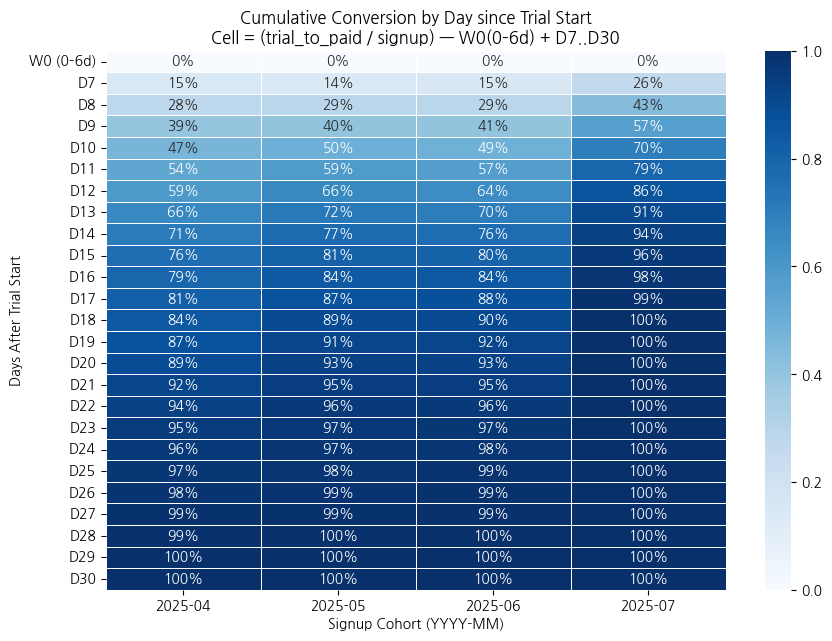

In [ ]:
# === Signup 코호트(열=YYYY-MM) × 경과일(행=W0(0~6일), D7..D30) ===
# 값 = 누적 전환율 (trial_to_paid / signup)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 0) 정규화
ph = plan_history.copy()
ph['reason'] = ph['reason'].astype(str).str.strip().str.lower()
ph['plan_status'] = ph['plan_status'].astype(str).str.strip().str.lower()
ph['change_time'] = pd.to_datetime(ph['change_time'], errors='coerce')

u = users.copy()
u['created_at'] = pd.to_datetime(u['created_at'], errors='coerce')

# 1) 핵심 타임포인트
signup = u[['user_id','created_at']].rename(columns={'created_at':'signup_ts'}).dropna()

trial_start = (ph.loc[ph['plan_status'].eq('trialing'), ['user_id','change_time']]
                 .sort_values('change_time')
                 .groupby('user_id', as_index=False).first()
                 .rename(columns={'change_time':'trial_start_ts'}))

paid = (ph.loc[ph['reason'].eq('trial_to_paid'), ['user_id','change_time']]
          .sort_values('change_time')
          .groupby('user_id', as_index=False).first()
          .rename(columns={'change_time':'paid_ts'}))

expired = (ph.loc[ph['reason'].eq('trial_expired'), ['user_id','change_time']]
            .sort_values('change_time')
            .groupby('user_id', as_index=False).first()
            .rename(columns={'change_time':'expired_ts'}))

base = (signup
        .merge(trial_start, on='user_id', how='left')
        .merge(paid, on='user_id', how='left')
        .merge(expired, on='user_id', how='left'))

# 2) 관찰 윈도우/라벨링
MAX_D = 30  # ← 20일에서 30일로 확장
base['window_start'] = np.where(base['trial_start_ts'].notna(), base['trial_start_ts'], base['signup_ts'])
base['window_start'] = pd.to_datetime(base['window_start'])
base['window_end']   = base['window_start'] + pd.to_timedelta(MAX_D, 'D')

paid_win = base['paid_ts'].where(base['paid_ts'].between(base['window_start'], base['window_end']))
exp_win  = base['expired_ts'].where(base['expired_ts'].between(base['window_start'], base['window_end']))

first_ts = pd.concat([paid_win, exp_win], axis=1).min(axis=1)
base['outcome'] = np.where(first_ts.isna(), 'pending',
                           np.where(paid_win.notna() & ((exp_win.isna()) | (paid_win <= exp_win)),
                                    'paid','expired'))

# 3) 코호트(열 라벨=YYYY-MM) + eligible + '경과 일' 계산
base['cohort_month_lbl'] = base['signup_ts'].dt.strftime('%Y-%m')
SNAPSHOT = pd.Timestamp.today().normalize()
eligible = base.loc[base['window_end'] <= SNAPSHOT].copy()

# paid가 '가장 이른 결과'인 경우만 경과일 계산
is_paid_first = eligible['outcome'].eq('paid')
eligible['paid_age_day'] = (eligible['paid_ts'] - eligible['window_start']).dt.days.where(is_paid_first)
eligible = eligible.loc[eligible['paid_age_day'].between(0, MAX_D, inclusive='both')]

# 4) 분모(코호트별 signup 수)
denom = (eligible.groupby('cohort_month_lbl')['user_id'].nunique()
                 .rename('N_signup'))

# 5) 일별 “그날 최초 유료” 카운트 → 누적 → 전환율
daily_counts = (eligible.groupby(['cohort_month_lbl','paid_age_day'])['user_id']
                        .nunique()
                        .unstack(fill_value=0))          # columns: 실제 등장한 day들만

# 빠진 일(day) 보강 및 정렬(0..MAX_D)
all_days = pd.Index(range(0, MAX_D+1), name='paid_age_day')
daily_counts = daily_counts.reindex(columns=all_days, fill_value=0).sort_index(axis=1)

# 누적합 → 전환율(분모=signup)
cum_counts = daily_counts.cumsum(axis=1)
cr_cum = (cum_counts.T / denom).T

# 6) 2025-04 이후 코호트만 사용
cr_cum = cr_cum.loc[cr_cum.index >= '2025-04']

# 7) 행을 W0(0~6일) + D7..D30로 재구성
row_labels = ['W0 (0–6d)'] + [f'D{d}' for d in range(7, MAX_D+1)]
plot_dict = {}
for cohort, row in cr_cum.iterrows():
    vals = [ row.loc[0:6].max() ]  # W0 = D0~6 누적(=D6 값)
    vals += [ row.get(d, np.nan) for d in range(7, MAX_D+1) ]
    plot_dict[cohort] = vals

plot_df = pd.DataFrame(plot_dict, index=row_labels)

# 8) 히트맵 (행=W0 + D7..D30, 열=코호트 YYYY-MM)
plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    plot_df, annot=True, fmt='.0%',
    cmap='Blues', vmin=0.0, vmax=1.0,
    cbar=True, linewidths=.5, linecolor='white'
)
ax.set_title('Cumulative Conversion by Day since Trial Start\nCell = (trial_to_paid / signup) — W0(0–6d) + D7..D30')
ax.set_xlabel('Signup Cohort (YYYY-MM)')
ax.set_ylabel('Days After Trial Start')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()


In [ ]:
plan_history['change_time'].max()

'2025-07-21 23:59:50'

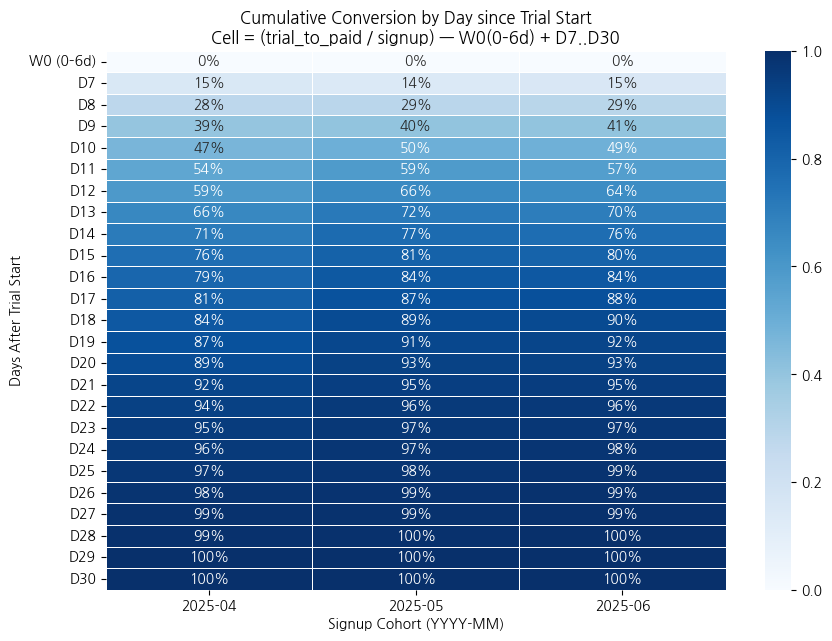

In [ ]:
# 6) 2025-04 이상 2025-06 이하만 사용 (7월 제외)
cr_cum = cr_cum.loc[(cr_cum.index >= '2025-04') & (cr_cum.index <= '2025-06')]

# 7) 행을 W0(0~6일) + D7..D30로 재구성
row_labels = ['W0 (0–6d)'] + [f'D{d}' for d in range(7, MAX_D+1)]
plot_dict = {}
for cohort, row in cr_cum.iterrows():
    vals = [ row.loc[0:6].max() ]  # W0 = D0~6 누적(=D6 값)
    vals += [ row.get(d, np.nan) for d in range(7, MAX_D+1) ]
    plot_dict[cohort] = vals

plot_df = pd.DataFrame(plot_dict, index=row_labels)

# 8) 히트맵
plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    plot_df, annot=True, fmt='.0%',
    cmap='Blues', vmin=0.0, vmax=1.0,
    cbar=True, linewidths=.5, linecolor='white'
)
ax.set_title('Cumulative Conversion by Day since Trial Start\nCell = (trial_to_paid / signup) — W0(0–6d) + D7..D30')
ax.set_xlabel('Signup Cohort (YYYY-MM)')
ax.set_ylabel('Days After Trial Start')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()


In [ ]:
# 마지막 값이 1.0인지 체크
print(cr_cum.max().max())  # 전 코호트, 전 일수 중 최대값


1.0


In [ ]:
MAX_D = 30
SNAPSHOT = pd.Timestamp.today().normalize()

# 1) 관찰 완료된 '모든 signup'로 분모 계산
eligible_signups = base.loc[base['window_end'] <= SNAPSHOT].copy()
denom = (eligible_signups.groupby('cohort_month_lbl')['user_id']
                      .nunique()
                      .rename('N_signup'))

# 2) 'paid만' 따로 뽑아 일수 버킷팅
paid_only = eligible_signups.loc[eligible_signups['outcome'].eq('paid')].copy()
paid_only['paid_age_day'] = (paid_only['paid_ts'] - paid_only['window_start']).dt.days
paid_only = paid_only.loc[paid_only['paid_age_day'].between(0, MAX_D)]

# 3) 일별 paid 카운트 → 누적 → 전환율(분모=signup)
daily_counts = (paid_only.groupby(['cohort_month_lbl','paid_age_day'])['user_id']
                        .nunique()
                        .unstack(fill_value=0)
                        .reindex(columns=range(0, MAX_D+1), fill_value=0)
                        .sort_index(axis=1))

cum_counts = daily_counts.cumsum(axis=1)
cr_cum = cum_counts.div(denom, axis=0)  # ← 분모는 '모든 signup'

# 4) 2025-04 ~ 2025-06만 사용(7월 제외)
cr_cum = cr_cum.loc[(cr_cum.index >= '2025-04') & (cr_cum.index <= '2025-06')]

# 5) 행 재구성: W0(0~6일) + D7..D30
row_labels = ['W0 (0–6d)'] + [f'D{d}' for d in range(7, MAX_D+1)]
plot_dict = {}
for cohort, row in cr_cum.iterrows():
    vals = [ row.loc[0:6].max() ]  # D6 값 = W0
    vals += [ row.get(d, np.nan) for d in range(7, MAX_D+1) ]
    plot_dict[cohort] = vals
plot_df = pd.DataFrame(plot_dict, index=row_labels)

# (선택) sanity check: 누적 paid가 100% 넘지 않는지
print('max value =', float(plot_df.max().max()))


max value = 0.34680350652127434


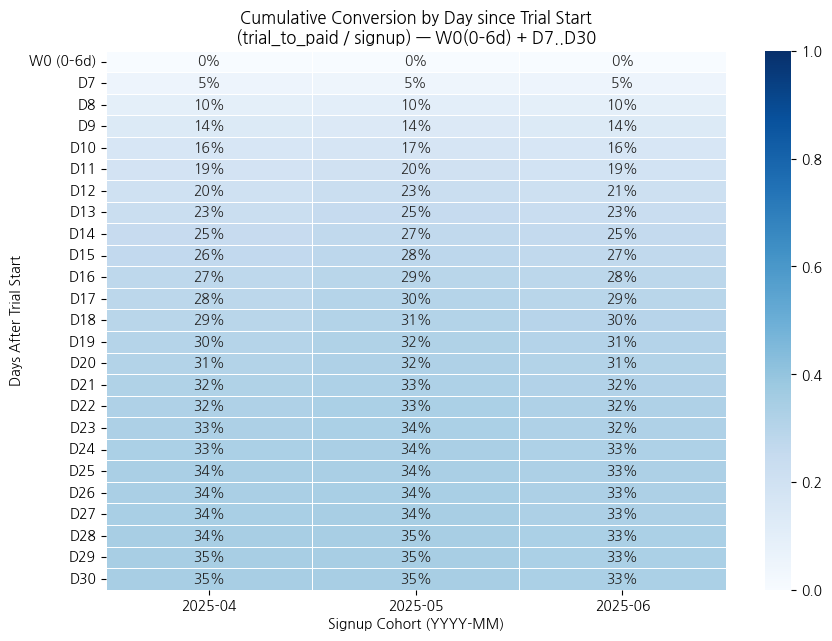

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

MAX_D = 30
SNAPSHOT = pd.Timestamp.today().normalize()

# 1) 분모: 모든 signup (관찰 완료된 코호트만)
eligible_signups = base.loc[base['window_end'] <= SNAPSHOT].copy()
denom = (eligible_signups.groupby('cohort_month_lbl')['user_id']
                      .nunique()
                      .rename('N_signup'))

# 2) 분자: paid만 필터링하여 경과일 계산
paid_only = eligible_signups.loc[eligible_signups['outcome'].eq('paid')].copy()
paid_only['paid_age_day'] = (paid_only['paid_ts'] - paid_only['window_start']).dt.days
paid_only = paid_only.loc[paid_only['paid_age_day'].between(0, MAX_D)]

# 3) 일별 paid 카운트 → 누적 → 전환율(분모=signup)
daily_counts = (paid_only.groupby(['cohort_month_lbl','paid_age_day'])['user_id']
                        .nunique()
                        .unstack(fill_value=0)
                        .reindex(columns=range(0, MAX_D+1), fill_value=0)
                        .sort_index(axis=1))
cum_counts = daily_counts.cumsum(axis=1)
cr_cum = cum_counts.div(denom, axis=0)

# 4) 2025-04 ~ 2025-06만 사용 (7월 제외)
cr_cum = cr_cum.loc[(cr_cum.index >= '2025-04') & (cr_cum.index <= '2025-06')]

# 5) 행: W0(0~6일) + D7..D30로 재구성
row_labels = ['W0 (0–6d)'] + [f'D{d}' for d in range(7, MAX_D+1)]
plot_dict = {}
for cohort, row in cr_cum.iterrows():
    vals = [ row.loc[0:6].max() ]  # D6 값 = W0
    vals += [ row.get(d, np.nan) for d in range(7, MAX_D+1) ]
    plot_dict[cohort] = vals
plot_df = pd.DataFrame(plot_dict, index=row_labels)

# 6) 히트맵 시각화
plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    plot_df, annot=True, fmt='.0%',
    cmap='Blues', vmin=0.0, vmax=1.0,
    cbar=True, linewidths=.5, linecolor='white'
)
ax.set_title('Cumulative Conversion by Day since Trial Start\n(trial_to_paid / signup) — W0(0–6d) + D7..D30')
ax.set_xlabel('Signup Cohort (YYYY-MM)')
ax.set_ylabel('Days After Trial Start')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()


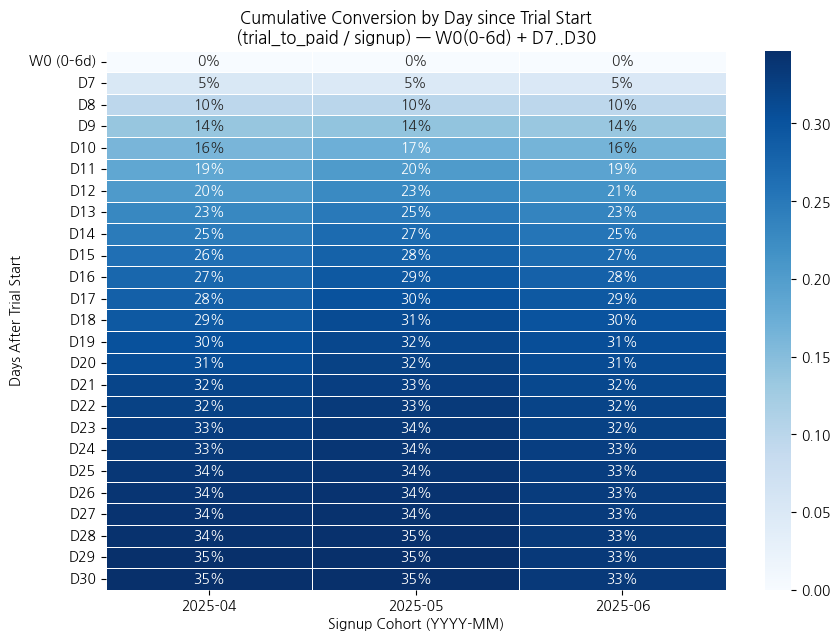

In [ ]:
# 색상 스케일 최댓값을 데이터 max로 지정
vmax_val = plot_df.max().max()  # ≈ 0.3468

plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    plot_df, annot=True, fmt='.0%',
    cmap='Blues', vmin=0.0, vmax=vmax_val,
    cbar=True, linewidths=.5, linecolor='white'
)
ax.set_title('Cumulative Conversion by Day since Trial Start\n(trial_to_paid / signup) — W0(0–6d) + D7..D30')
ax.set_xlabel('Signup Cohort (YYYY-MM)')
ax.set_ylabel('Days After Trial Start')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()


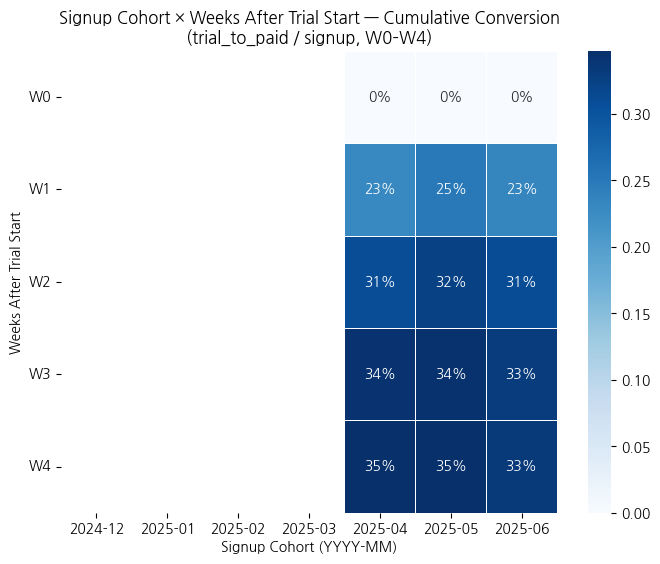

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ===== 파라미터 =====
LAST_DAY = 31            # 한 달 최대 31일
MAX_WEEK = LAST_DAY // 7 # 31일 ⇒ 4 (W0~W4)
EXCLUDE_MONTH = '2025-07'  # 7월 제외

# --- 0) 정규화 & 타임스탬프 지정 ---
ph = plan_history.copy()
ph['reason'] = ph['reason'].astype(str).str.strip().str.lower()
ph['plan_status'] = ph['plan_status'].astype(str).str.strip().str.lower()
ph['change_time'] = pd.to_datetime(ph['change_time'], errors='coerce')

u = users.copy()
u['created_at'] = pd.to_datetime(u['created_at'], errors='coerce')

# --- 1) 핵심 타임포인트 ---
signup = u[['user_id','created_at']].rename(columns={'created_at':'signup_ts'}).dropna()

trial_start = (ph.loc[ph['plan_status'].eq('trialing'), ['user_id','change_time']]
                 .sort_values('change_time')
                 .groupby('user_id', as_index=False).first()
                 .rename(columns={'change_time':'trial_start_ts'}))

paid = (ph.loc[ph['reason'].eq('trial_to_paid'), ['user_id','change_time']]
          .sort_values('change_time')
          .groupby('user_id', as_index=False).first()
          .rename(columns={'change_time':'paid_ts'}))

expired = (ph.loc[ph['reason'].eq('trial_expired'), ['user_id','change_time']]
            .sort_values('change_time')
            .groupby('user_id', as_index=False).first()
            .rename(columns={'change_time':'expired_ts'}))

base = (signup
        .merge(trial_start, on='user_id', how='left')
        .merge(paid, on='user_id', how='left')
        .merge(expired, on='user_id', how='left'))

# --- 2) 관찰 윈도우 & 결과 라벨 ---
base['window_start'] = np.where(base['trial_start_ts'].notna(), base['trial_start_ts'], base['signup_ts'])
base['window_start'] = pd.to_datetime(base['window_start'])
base['window_end']   = base['window_start'] + pd.to_timedelta(LAST_DAY, 'D')  # D0~D31 포함

paid_win = base['paid_ts'].where(base['paid_ts'].between(base['window_start'], base['window_end']))
exp_win  = base['expired_ts'].where(base['expired_ts'].between(base['window_start'], base['window_end']))
first_ts = pd.concat([paid_win, exp_win], axis=1).min(axis=1)

base['outcome'] = np.where(first_ts.isna(), 'pending',
                           np.where(paid_win.notna() & ((exp_win.isna()) | (paid_win <= exp_win)),
                                    'paid','expired'))

# --- 3) 코호트 라벨(YYYY-MM 문자열로 깔끔하게) & eligible ---
base['cohort_month_lbl'] = base['signup_ts'].dt.strftime('%Y-%m')  # ← 타임스탬프 꼬리 제거
SNAPSHOT = pd.Timestamp.today().normalize()
eligible_signups = base.loc[base['window_end'] <= SNAPSHOT].copy()

# 7월 제외
eligible_signups = eligible_signups.loc[eligible_signups['cohort_month_lbl'] != EXCLUDE_MONTH]

# --- 4) 분모: 코호트별 signup 수 ---
denom = (eligible_signups.groupby('cohort_month_lbl')['user_id']
                      .nunique()
                      .rename('N_signup'))

# --- 5) 주차 버킷: ‘해당 주까지 누적 paid’ / signup ---
paid_only = eligible_signups.loc[eligible_signups['outcome'].eq('paid')].copy()
paid_only['age_days'] = (paid_only['paid_ts'] - paid_only['window_start']).dt.days
paid_only = paid_only.loc[paid_only['age_days'].between(0, LAST_DAY, inclusive='both')]

paid_only['age_week'] = np.floor_divide(paid_only['age_days'], 7).astype(int)
paid_only['age_week'] = paid_only['age_week'].clip(0, MAX_WEEK)  # W0~W4

# 주차별 "그 주에 최초 유료" 카운트
wk_counts = (paid_only.groupby(['cohort_month_lbl','age_week'])['user_id']
                       .nunique()
                       .unstack(fill_value=0))

# 빠진 주차 보강 & 정렬
for w in range(0, MAX_WEEK+1):
    if w not in wk_counts.columns:
        wk_counts[w] = 0
wk_counts = wk_counts[sorted(wk_counts.columns)]

# 누적합 → 전환율
wk_cum = wk_counts.cumsum(axis=1)
cr_weekly_cum = wk_cum.div(denom, axis=0)

# --- 6) 히트맵용 테이블(W0~W4) 만들기 ---
col_map = {w: f'W{w}' for w in range(0, MAX_WEEK+1)}  # {0:'W0',...,4:'W4'}
heat_df = cr_weekly_cum.rename(columns=col_map).sort_index()

# --- 7) 시각화 ---
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    heat_df.T,                   # 행=주차, 열=코호트
    annot=True, fmt='.0%',
    cmap='Blues',
    vmin=0.0, vmax=max(0.001, heat_df.max().max()),  # 데이터 최대치에 맞춰 대비 강화
    cbar=True, linewidths=.5, linecolor='white'
)
ax.set_title('Signup Cohort × Weeks After Trial Start — Cumulative Conversion\n(trial_to_paid / signup, W0–W4)')
ax.set_xlabel('Signup Cohort (YYYY-MM)')
ax.set_ylabel('Weeks After Trial Start')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()


## 보기 좋게 수정한 찐 코호트 분석
문제점 :유료 전환 후 유지는 잘 되지만, 체험(trial) 후 유료 전환을 하지 않은 고객 비율이 높다.   
목표 : 코호트 분석을 통해 > 월별/ 주간별 전환율을 확인해보고 이상점이 있는지 발견해보자  
전환율의 정의 : plan_history[reason] > trial_to_paid / sign_up 의 비율로 계산

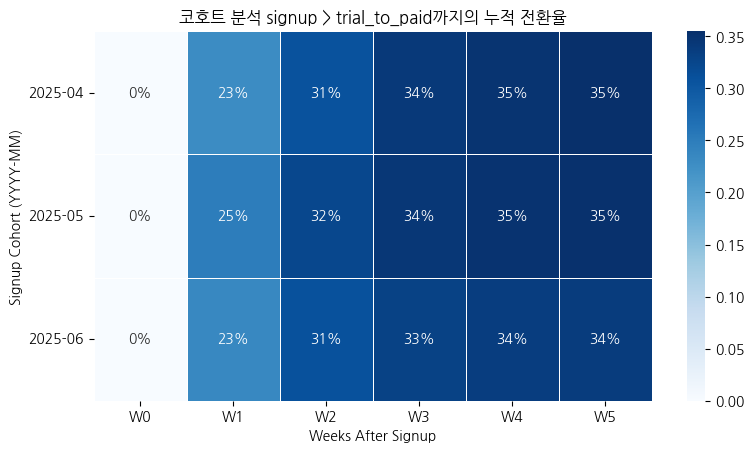

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ===== 파라미터 =====
LAST_DAY = 41            # 0~41일 → W0~W5
MAX_WEEK = LAST_DAY // 7
INCLUDE_MONTHS = ['2025-04','2025-05','2025-06']  # 4~6월 코호트(=signup 월)
SNAPSHOT = pd.Timestamp.today().normalize()

# --- 0) 정규화 ---
ph = plan_history.copy()
ph['reason'] = ph['reason'].astype(str).str.strip().str.lower()
ph['plan_status'] = ph['plan_status'].astype(str).str.strip().str.lower()
ph['change_time'] = pd.to_datetime(ph['change_time'], errors='coerce')

u = users.copy()
u['created_at'] = pd.to_datetime(u['created_at'], errors='coerce')

# --- 1) 핵심 타임포인트 (signup anchor) ---
signup = u[['user_id','created_at']].rename(columns={'created_at':'signup_ts'}).dropna()

paid = (ph.loc[ph['reason'].eq('trial_to_paid'), ['user_id','change_time']]
          .sort_values('change_time')
          .groupby('user_id', as_index=False).first()
          .rename(columns={'change_time':'paid_ts'}))

base = signup.merge(paid, on='user_id', how='left')
base['cohort_month_lbl'] = base['signup_ts'].dt.strftime('%Y-%m')

# --- 2) 관찰 가능한 코호트 제한(검열 보정) ---
eligible = base.loc[
    base['cohort_month_lbl'].isin(INCLUDE_MONTHS) &
    (base['signup_ts'] + pd.to_timedelta(LAST_DAY, 'D') <= SNAPSHOT)
].copy()

# --- 3) 분모: 코호트별 signup 수 ---
denom = (eligible.groupby('cohort_month_lbl')['user_id']
                  .nunique()
                  .rename('N_signup'))

# --- 4) 분자: 가입 후 주차별(가입 이후만) 최초 유료 전환 → 누적 → 전환율 ---
paid_only = eligible.loc[eligible['paid_ts'].notna()].copy()
paid_only['age_days'] = (paid_only['paid_ts'] - paid_only['signup_ts']).dt.days
paid_only = paid_only.loc[paid_only['age_days'].between(0, LAST_DAY, inclusive='both')]

paid_only['age_week'] = np.floor_divide(paid_only['age_days'], 7).astype(int)
paid_only['age_week'] = paid_only['age_week'].clip(0, MAX_WEEK)  # W0~W5

wk_counts = (paid_only.groupby(['cohort_month_lbl','age_week'])['user_id']
                       .nunique()
                       .unstack(fill_value=0))

# 빠진 주차 보강 & 정렬
for w in range(0, MAX_WEEK+1):
    if w not in wk_counts.columns:
        wk_counts[w] = 0
wk_counts = wk_counts[sorted(wk_counts.columns)]  # 0..5

# 누적합 → 전환율(분모=signup)
wk_cum = wk_counts.cumsum(axis=1)
cr_weekly_cum = wk_cum.div(denom, axis=0)

# --- 5) 히트맵 테이블: 행=코호트(4~6월), 열=W0~W5 ---
col_map = {w: f'W{w}' for w in range(0, MAX_WEEK+1)}
heat_df = (cr_weekly_cum.rename(columns=col_map)
           .reindex(INCLUDE_MONTHS)              # 4~6월 순서
           .loc[:, [f'W{w}' for w in range(0, MAX_WEEK+1)]])

# --- 6) 시각화 ---
plt.figure(figsize=(9, 4.8))
ax = sns.heatmap(
    heat_df,
    annot=True, fmt='.0%',
    cmap='Blues',
    vmin=0.0, vmax=max(0.001, heat_df.values.max()),
    cbar=True, linewidths=.5, linecolor='white'
)
ax.set_title('코호트 분석 signup > trial_to_paid까지의 누적 전환율')
ax.set_xlabel('Weeks After Signup')
ax.set_ylabel('Signup Cohort (YYYY-MM)')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()


## 요청받은 코호트 시계열 그래프

In [ ]:
!pip install koreanize_matplotlib


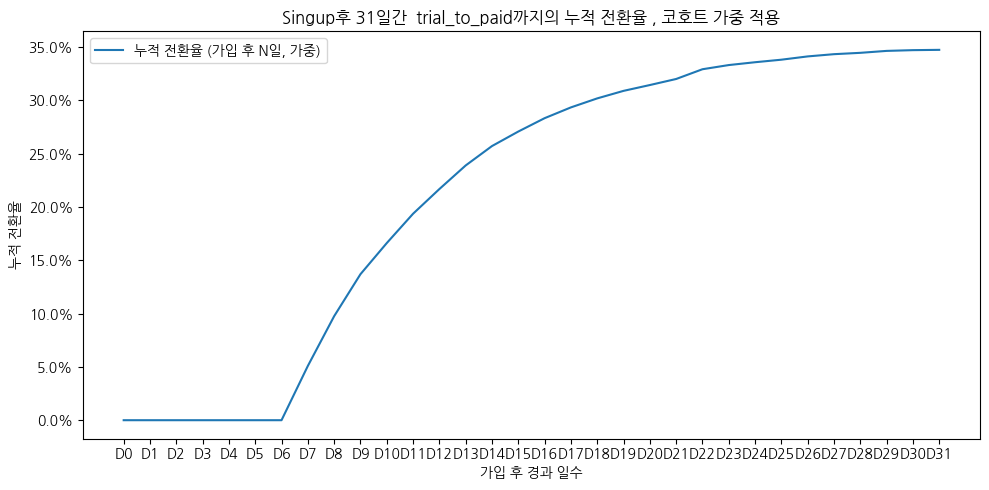

,day,cum_cr
0,0,0.000000
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000
5,5,0.000000
6,6,0.000000
7,7,0.050910
8,8,0.097597
9,9,0.136999


In [ ]:
# Trial → Paid 누적 전환율 (가입 후 D0~D31, 4~6월, 코호트 가중, 검열 보정)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from matplotlib.ticker import PercentFormatter

# -----------------------------
# 0) 원본 정리
# -----------------------------
df = plan_history.copy()
df["reason"] = df["reason"].astype(str).str.strip().str.lower()
df["change_time"] = pd.to_datetime(df["change_time"])

# -----------------------------
# 1) 4~6월 signup 코호트 구성 (월단위)
#    - 같은 유저가 같은 달에 여러 번 signup 해도 첫 건만
# -----------------------------
signup_raw = df[df["reason"] == "signup"].copy()
signup_raw["ym"] = signup_raw["change_time"].dt.to_period("M")

signup_46 = (
    signup_raw[signup_raw["change_time"].dt.month.isin([4, 5, 6])]
    .sort_values(["user_id", "change_time"])
    .drop_duplicates(subset=["user_id", "ym"], keep="first")
    .rename(columns={"change_time": "signup_time"})
    [["user_id", "ym", "signup_time"]]
)

# 코호트별(월) 분모: 유니크 유저 수
signup_total = signup_46.groupby("ym")["user_id"].nunique().rename("signup_total")

# -----------------------------
# 2) trial_to_paid와 조인하여 "가입 후 경과일" 계산
#    - 각 (user_id, ym)에서 0일 이상인 전환 중 최솟값만 사용
# -----------------------------
paid_raw = df[df["reason"] == "trial_to_paid"][["user_id", "change_time"]].rename(
    columns={"change_time": "paid_time"}
)

age = signup_46.merge(paid_raw, on="user_id", how="left")
age["days_after"] = (age["paid_time"] - age["signup_time"]).dt.days

# 음수/결측 제거 후, 유저×코호트별 최소 경과일만 사용
age_valid = (
    age.loc[age["days_after"].notna() & (age["days_after"] >= 0)]
    .sort_values(["user_id", "ym", "days_after"])
    .drop_duplicates(subset=["user_id", "ym"], keep="first")
)

# -----------------------------
# 3) 코호트별 D0~D31 전환 수, 누적 전환율
# -----------------------------
cols = pd.Index(range(0, 32))  # D0~D31

paid_by_day = (
    age_valid.groupby(["ym", "days_after"])["user_id"]
    .nunique()
    .unstack("days_after")
    .reindex(columns=cols, fill_value=0)
)

paid_cum = paid_by_day.cumsum(axis=1)

# 코호트별 누적 전환율 (누적 전환 / 코호트 분모)
cr_by_cohort = (paid_cum.T / signup_total).T  # index=ym, columns=D0..D31
cr_by_cohort = cr_by_cohort.reindex(columns=cols).ffill(axis=1).fillna(0.0)

# -----------------------------
# 4) 검열 보정: 각 D에서 '관찰 가능한 코호트'만 가중평균
#    - latest_ts 기준으로, 코호트 내 가장 늦은 signup과의 차이를 max D로 사용
# -----------------------------
latest_ts = df["change_time"].max()
last_signup_per_cohort = (
    signup_46.groupby("ym")["signup_time"].max()
)
max_d = (latest_ts - last_signup_per_cohort).dt.days.clip(lower=0)

weights = signup_total.reindex(cr_by_cohort.index).fillna(0)  # 코호트 가중은 분모 수

y_vals = []
for d in cols:
    mask = (max_d >= d) & (weights > 0)  # D=d까지 관찰 가능한 코호트만
    if mask.any():
        num = (cr_by_cohort.loc[mask, d] * weights[mask]).sum()
        den = weights[mask].sum()
        y_vals.append(num / den)
    else:
        y_vals.append(np.nan)

# 누적율 특성상 비감소: 앞값 채우고(FFILL) 단조증가 강제
y = pd.Series(y_vals, index=cols).ffill().fillna(0.0).to_numpy()
y = np.maximum.accumulate(y)

# -----------------------------
# 5) 시각화
# -----------------------------
x = np.arange(0, 32)
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="누적 전환율 (가입 후 N일, 가중)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(x, [f"D{d}" for d in x])
plt.xlabel("가입 후 경과 일수")
plt.ylabel("누적 전환율")
plt.title("Singup후 31일간  trial_to_paid까지의 누적 전환율 , 코호트 가중 적용")
plt.legend()
plt.tight_layout()
plt.show()

# (선택) 값 확인
pd.DataFrame({"day": x, "cum_cr": y}).head(12)


## 코호트 분석 시각화 코드

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ===== 파라미터 =====
LAST_DAY = 41            # 0~41일 → W0~W5
MAX_WEEK = LAST_DAY // 7
INCLUDE_MONTHS = ['2025-04','2025-05','2025-06']  # 4~6월 코호트(=signup 월)
SNAPSHOT = pd.Timestamp.today().normalize()

# --- 0) 정규화 ---
ph = plan_history.copy()
ph['reason'] = ph['reason'].astype(str).str.strip().str.lower()
ph['plan_status'] = ph['plan_status'].astype(str).str.strip().str.lower()
ph['change_time'] = pd.to_datetime(ph['change_time'], errors='coerce')

u = users.copy()
u['created_at'] = pd.to_datetime(u['created_at'], errors='coerce')

# --- 1) 핵심 타임포인트 (signup anchor) ---
signup = u[['user_id','created_at']].rename(columns={'created_at':'signup_ts'}).dropna()

paid = (ph.loc[ph['reason'].eq('trial_to_paid'), ['user_id','change_time']]
          .sort_values('change_time')
          .groupby('user_id', as_index=False).first()
          .rename(columns={'change_time':'paid_ts'}))

base = signup.merge(paid, on='user_id', how='left')
base['cohort_month_lbl'] = base['signup_ts'].dt.strftime('%Y-%m')

# --- 2) 관찰 가능한 코호트 제한(검열 보정) ---
eligible = base.loc[
    base['cohort_month_lbl'].isin(INCLUDE_MONTHS) &
    (base['signup_ts'] + pd.to_timedelta(LAST_DAY, 'D') <= SNAPSHOT)
].copy()

# --- 3) 분모: 코호트별 signup 수 ---
denom = (eligible.groupby('cohort_month_lbl')['user_id']
                  .nunique()
                  .rename('N_signup'))

# --- 4) 분자: 가입 후 주차별(가입 이후만) 최초 유료 전환 → 누적 → 전환율 ---
paid_only = eligible.loc[eligible['paid_ts'].notna()].copy()
paid_only['age_days'] = (paid_only['paid_ts'] - paid_only['signup_ts']).dt.days
paid_only = paid_only.loc[paid_only['age_days'].between(0, LAST_DAY, inclusive='both')]

paid_only['age_week'] = np.floor_divide(paid_only['age_days'], 7).astype(int)
paid_only['age_week'] = paid_only['age_week'].clip(0, MAX_WEEK)  # W0~W5

wk_counts = (paid_only.groupby(['cohort_month_lbl','age_week'])['user_id']
                       .nunique()
                       .unstack(fill_value=0))

# 빠진 주차 보강 & 정렬
for w in range(0, MAX_WEEK+1):
    if w not in wk_counts.columns:
        wk_counts[w] = 0
wk_counts = wk_counts[sorted(wk_counts.columns)]  # 0..5

# 누적합 → 전환율(분모=signup)
wk_cum = wk_counts.cumsum(axis=1)
cr_weekly_cum = wk_cum.div(denom, axis=0)

# --- 5) 히트맵 테이블: 행=코호트(4~6월), 열=W0~W5 ---
col_map = {w: f'W{w}' for w in range(0, MAX_WEEK+1)}
heat_df = (cr_weekly_cum.rename(columns=col_map)
           .reindex(INCLUDE_MONTHS)              # 4~6월 순서
           .loc[:, [f'W{w}' for w in range(0, MAX_WEEK+1)]])

# --- 6) 시각화 ---
plt.figure(figsize=(9, 4.8))
ax = sns.heatmap(
    heat_df,
    annot=True, fmt='.0%',
    cmap='Blues',
    vmin=0.0, vmax=max(0.001, heat_df.values.max()),
    cbar=True, linewidths=.5, linecolor='white'
)
ax.set_title('코호트 분석 signup > trial_to_paid까지의 누적 전환율')
ax.set_xlabel('Weeks After Signup')
ax.set_ylabel('Signup Cohort (YYYY-MM)')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()


In [ ]:
# Trial → Paid 누적 전환율 (가입 후 D0~D31, 4~6월, 코호트 가중, 검열 보정)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
from matplotlib.ticker import PercentFormatter

# -----------------------------
# 0) 원본 정리
# -----------------------------
df = plan_history.copy()
df["reason"] = df["reason"].astype(str).str.strip().str.lower()
df["change_time"] = pd.to_datetime(df["change_time"])

# -----------------------------
# 1) 4~6월 signup 코호트 구성 (월단위)
#    - 같은 유저가 같은 달에 여러 번 signup 해도 첫 건만
# -----------------------------
signup_raw = df[df["reason"] == "signup"].copy()
signup_raw["ym"] = signup_raw["change_time"].dt.to_period("M")

signup_46 = (
    signup_raw[signup_raw["change_time"].dt.month.isin([4, 5, 6])]
    .sort_values(["user_id", "change_time"])
    .drop_duplicates(subset=["user_id", "ym"], keep="first")
    .rename(columns={"change_time": "signup_time"})
    [["user_id", "ym", "signup_time"]]
)

# 코호트별(월) 분모: 유니크 유저 수
signup_total = signup_46.groupby("ym")["user_id"].nunique().rename("signup_total")

# -----------------------------
# 2) trial_to_paid와 조인하여 "가입 후 경과일" 계산
#    - 각 (user_id, ym)에서 0일 이상인 전환 중 최솟값만 사용
# -----------------------------
paid_raw = df[df["reason"] == "trial_to_paid"][["user_id", "change_time"]].rename(
    columns={"change_time": "paid_time"}
)

age = signup_46.merge(paid_raw, on="user_id", how="left")
age["days_after"] = (age["paid_time"] - age["signup_time"]).dt.days

# 음수/결측 제거 후, 유저×코호트별 최소 경과일만 사용
age_valid = (
    age.loc[age["days_after"].notna() & (age["days_after"] >= 0)]
    .sort_values(["user_id", "ym", "days_after"])
    .drop_duplicates(subset=["user_id", "ym"], keep="first")
)

# -----------------------------
# 3) 코호트별 D0~D31 전환 수, 누적 전환율
# -----------------------------
cols = pd.Index(range(0, 32))  # D0~D31

paid_by_day = (
    age_valid.groupby(["ym", "days_after"])["user_id"]
    .nunique()
    .unstack("days_after")
    .reindex(columns=cols, fill_value=0)
)

paid_cum = paid_by_day.cumsum(axis=1)

# 코호트별 누적 전환율 (누적 전환 / 코호트 분모)
cr_by_cohort = (paid_cum.T / signup_total).T  # index=ym, columns=D0..D31
cr_by_cohort = cr_by_cohort.reindex(columns=cols).ffill(axis=1).fillna(0.0)

# -----------------------------
# 4) 검열 보정: 각 D에서 '관찰 가능한 코호트'만 가중평균
#    - latest_ts 기준으로, 코호트 내 가장 늦은 signup과의 차이를 max D로 사용
# -----------------------------
latest_ts = df["change_time"].max()
last_signup_per_cohort = (
    signup_46.groupby("ym")["signup_time"].max()
)
max_d = (latest_ts - last_signup_per_cohort).dt.days.clip(lower=0)

weights = signup_total.reindex(cr_by_cohort.index).fillna(0)  # 코호트 가중은 분모 수

y_vals = []
for d in cols:
    mask = (max_d >= d) & (weights > 0)  # D=d까지 관찰 가능한 코호트만
    if mask.any():
        num = (cr_by_cohort.loc[mask, d] * weights[mask]).sum()
        den = weights[mask].sum()
        y_vals.append(num / den)
    else:
        y_vals.append(np.nan)

# 누적율 특성상 비감소: 앞값 채우고(FFILL) 단조증가 강제
y = pd.Series(y_vals, index=cols).ffill().fillna(0.0).to_numpy()
y = np.maximum.accumulate(y)

# -----------------------------
# 5) 시각화
# -----------------------------
x = np.arange(0, 32)
plt.figure(figsize=(10, 5))
plt.plot(x, y, label="누적 전환율 (가입 후 N일, 가중)")
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(x, [f"D{d}" for d in x])
plt.xlabel("가입 후 경과 일수")
plt.ylabel("누적 전환율")
plt.title("Singup후 31일간  trial_to_paid까지의 누적 전환율 , 코호트 가중 적용")
plt.legend()
plt.tight_layout()
plt.show()

# (선택) 값 확인
pd.DataFrame({"day": x, "cum_cr": y}).head(12)


## 인사이트
코호트 그래프를 통해 전환율이 급격히 올라가는 시점을 확인했고
이 시기에 마케팅을 하면 효율적일 것